In [1]:
import os
import numpy as np
from numpy.random import shuffle, seed
np.set_printoptions(precision=5, suppress=True)
import matplotlib.pyplot as plt
import SimpleITK as sitk
import pandas as pd
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy#, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalCrossentropy as cce, MeanIoU
import tensorflow.keras.backend as K
import gc

from modules import *
from unet_keras.unet import load_2d_unet 

In [2]:
# general parameters

source_folder         = 'source_data'
dataset_folder        = 'dataset'

cy                    = [0,0,0,1,1,1,2,2,2] # multiplot lines idx
cx                    = [0,1,2,0,1,2,0,1,2] # multiplot columns idx

n_input_channels      = 1                   # number of source image layers
n_output_channels     = 20                  # number of segmentation classes
z_dim                 = 128                 # required image dimension in Z plane

trainval_files        = [2,3,4,5,6,7]       # filenames for train and validation
predict_file          = [1]                 # filename for testing

threshold             = 0.3                 # segmentation 0...1 threshold  

## 1. Анализ полученных данных

### 1.1 Пространственное положение снимков, определение направления поворота

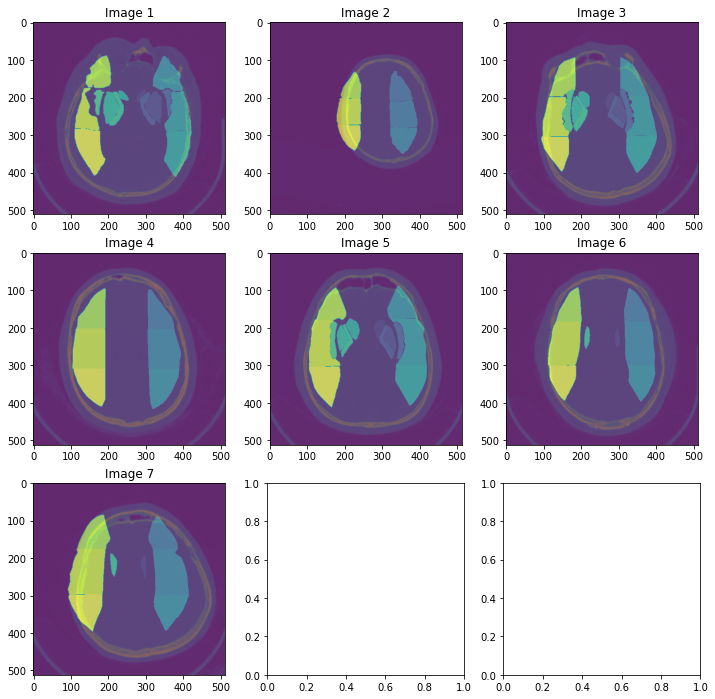

In [3]:
# загружаем файлы как есть, без поворотов, наблюдаем смещения
fig, axs = plt.subplots(3, 3, figsize=(12,12))
split = 60
for i in range(9):
    try:
        img_x, img_y = load_and_process_images(os.path.join(source_folder), i+1, None)
        slice_x = img_x[...,split]
        slice_y = img_y[...,split]
        axs[cy[i],cx[i]].set_title('Image '+str(i+1))
        axs[cy[i],cx[i]].imshow(slice_x, alpha=0.6), axs[cy[i],cx[i]].imshow(slice_y, alpha=0.6);
    except:
        break

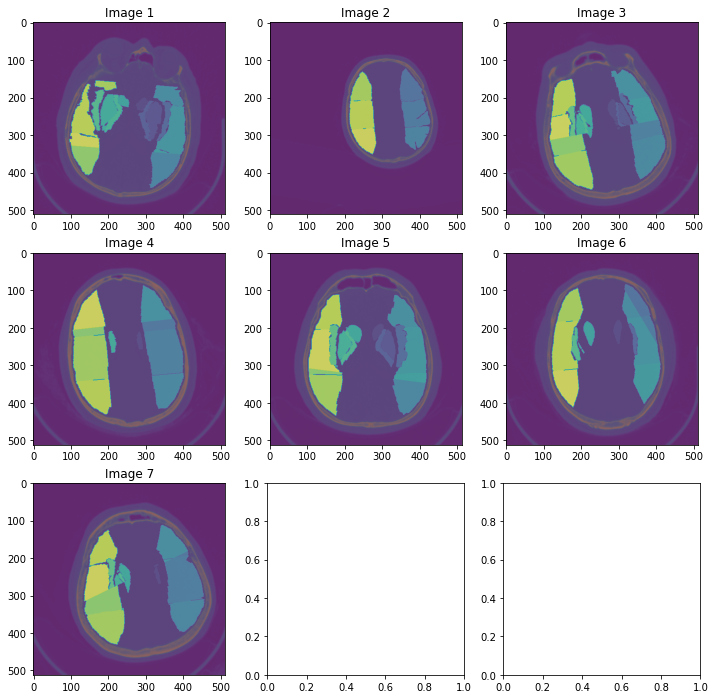

In [4]:
# загружаем файлы c поворотом разметки относительно снимка
fig, axs = plt.subplots(3, 3, figsize=(12,12))
split = 60
for i in range(9):
    try:
        img_x, img_y = load_and_process_images(os.path.join(source_folder), i+1, 'y')
        slice_x = img_x[...,split]
        slice_y = img_y[...,split]
        axs[cy[i],cx[i]].set_title('Image '+str(i+1))
        axs[cy[i],cx[i]].imshow(slice_x, alpha=0.6), axs[cy[i],cx[i]].imshow(slice_y, alpha=0.6);
    except:
        break

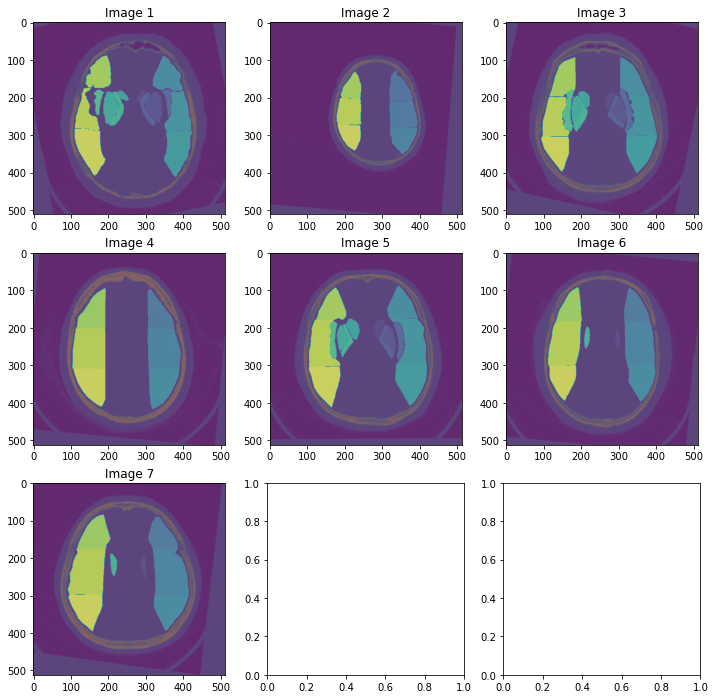

In [5]:
# загружаем файлы c поворотом снимка относительно разметки
fig, axs = plt.subplots(3, 3, figsize=(12,12))
split = 60
for i in range(9):
    try:
        img_x, img_y = load_and_process_images(os.path.join(source_folder), i+1, 'x')
        slice_x = img_x[...,split]
        slice_y = img_y[...,split]
        axs[cy[i],cx[i]].set_title('Image '+str(i+1))
        axs[cy[i],cx[i]].imshow(slice_x, alpha=0.6), axs[cy[i],cx[i]].imshow(slice_y, alpha=0.6);
    except:
        break

### 1.2 Оценка размерностей и динамического диапазона снимков, определение порядка препроцессинга

In [6]:
# загрузка файлов снимков и разметки, размещение их 3D массивов в соответствующих списках images_x и images_y
maxZ = 0
minZ = 1e6
color_min = 0
color_max = 0
images_x = []
images_y = []

for i in range(7):
    img_x, img_y = load_and_process_images(os.path.join(source_folder), i+1, None)
    assert img_x.shape==img_y.shape, 'X != y for img %i' % i
    if img_x.shape[2]>maxZ: maxZ=img_x.shape[2]
    if img_x.shape[2]<minZ: minZ=img_x.shape[2]  
    if np.min(img_x)<color_min: color_min=np.min(img_x)
    if np.max(img_x)>color_max: color_max=np.max(img_x) 
    classes = np.unique(img_y)
    print('Image %i::\nX shape: %s, y shape: %s, min color: %i, max_color: %i \nSegmentation classes: %s, totally: %i' % 
          (i+1, img_x.shape, img_y.shape, np.min(img_x), np.max(img_x), classes, len(classes)-1))    
    images_x.append(img_x)
    images_y.append(img_y)
    
print('\nMaximum Z dimension:', maxZ)
print('Minimum Z dimension:', minZ)
print('\nColor minimum:', color_min)
print('Color maximum:', color_max)

Image 1::
X shape: (512, 512, 116), y shape: (512, 512, 116), min color: -1024, max_color: 3071 
Segmentation classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20], totally: 20
Image 2::
X shape: (512, 512, 98), y shape: (512, 512, 98), min color: -1024, max_color: 2199 
Segmentation classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20], totally: 20
Image 3::
X shape: (512, 512, 104), y shape: (512, 512, 104), min color: -1024, max_color: 2238 
Segmentation classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20], totally: 20
Image 4::
X shape: (512, 512, 103), y shape: (512, 512, 103), min color: -1024, max_color: 3071 
Segmentation classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20], totally: 20
Image 5::
X shape: (512, 512, 104), y shape: (512, 512, 104), min color: -1024, max_color: 3071 
Segmentation classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20], totally: 20
Image 6::
X shape

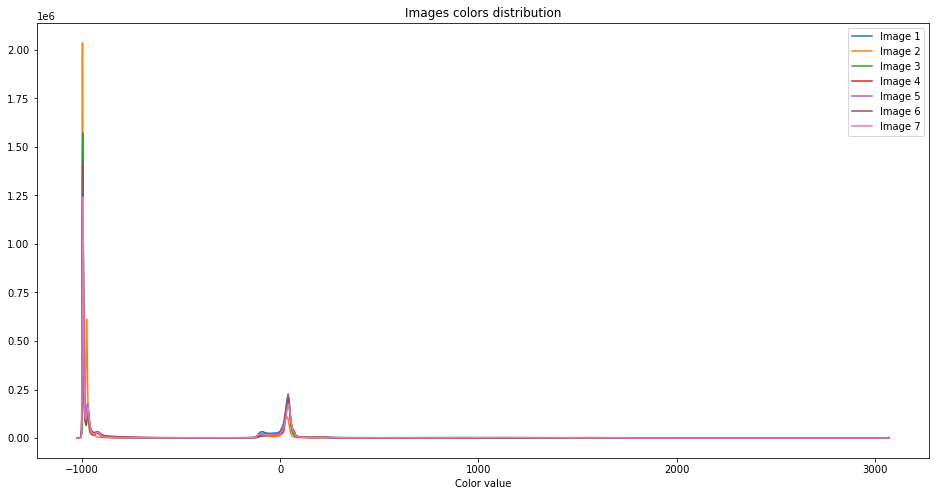

In [7]:
# распределение плотности цвета по всем снимкам
dfx = pd.DataFrame((np.arange(color_min,color_max+1)),columns=['Color value'])
for i in range(len(images_x)):
    img = np.ravel(images_x[i])
    a = pd.DataFrame((pd.value_counts(img)),columns=['Image '+str(i+1)])
    dfx = dfx.join(a['Image '+str(i+1)], on=dfx['Color value'], how='left')
dfx.fillna(0, inplace=True)
dfx = dfx.astype('int64')
dfx.plot(x="Color value", figsize=(16,8), title = 'Images colors distribution');

In [8]:
# на всякий случай - проверка наличия пустых значений
np.sum(dfx.isna())

Color value    0
Image 1        0
Image 2        0
Image 3        0
Image 4        0
Image 5        0
Image 6        0
Image 7        0
dtype: int64

На диаграмме выше явно видны два пика плотности цветов. Резко отрицательные и резко положительные значения цвета относятся к пикселям вне объекта на снимке. Если их убрать, то модели будет проще сконцентрироваться на сути снимка. Отбросим все пиксели вне диапазона(-255, 255) и увеличим масштаб графика.

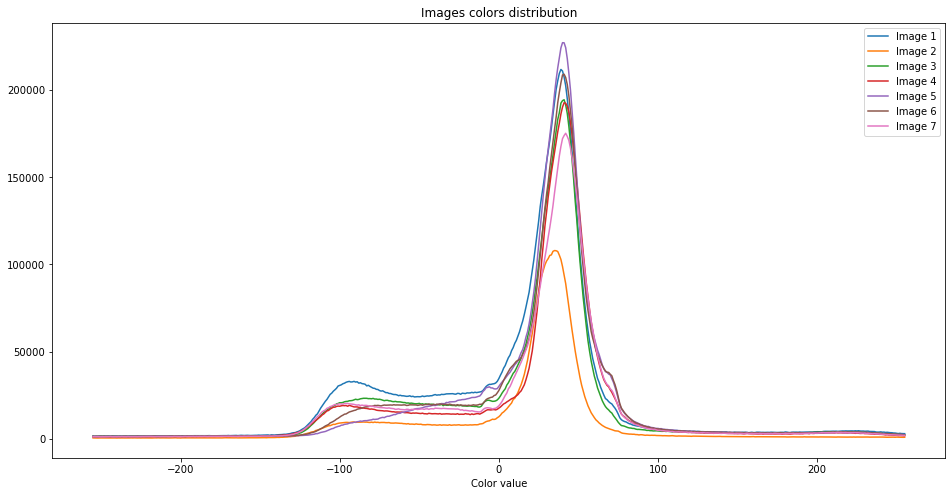

In [9]:
# распределение цветов в диапазоне -255, 255
df = dfx[dfx['Color value'].between(-255,255)].copy()
df.plot(x="Color value", figsize=(16,8), title = 'Images colors distribution');

Логично бы было уложить диапазон цветов в интервал -127...127. Посчитаем, при каких границах потери информации минимальны (=в интервал попадает максимальное число пикселей):

In [10]:
# подбор оптимального окна и расчет количества потерянных пикселей
max_pixels=0
best_window = []
for left_edge in range(-255,1):
    right_edge = left_edge+254
    if np.sum(df[df['Color value'].between(left_edge, right_edge)][df.columns[1:8]].values)>max_pixels:
        max_pixels=np.sum(df[df['Color value'].between(left_edge, right_edge)][df.columns[1:8]].values)
        best_window = [left_edge, right_edge]
loss = 1-max_pixels/np.sum(df[df.columns[1:8]].values)
print(loss, best_window)

0.06180759277554404 [-124, 130]


In [11]:
# таблица распределений цветов
df=dfx[dfx['Color value'].between(best_window[0], best_window[1])]
df

,Color value,Image 1,Image 2,Image 3,Image 4,Image 5,Image 6,Image 7
900,-124,5223,2189,3572,4503,1883,2197,4337
901,-123,5762,2427,4147,4997,1922,2344,4966
902,-122,6287,2575,4629,5464,1938,2554,5703
903,-121,7138,2936,5270,6210,2045,2631,6454
904,-120,8089,3206,5877,6847,2094,2800,7173
...,...,...,...,...,...,...,...,...
1150,126,4135,1389,3628,3437,4120,4033,3363
1151,127,4053,1444,3593,3375,4066,4007,3469
1152,128,4087,1426,3607,3497,4002,3851,3455
1153,129,4030,1390,3415,3301,4032,3880,3443


Наивыгоднейшее окно: [-124, 130], при этом потери составляют 6% пикселей. Визуально можно грубо оценить, встречаются ли пиксели вне этого диапазона на интересующих нас областях снимков:

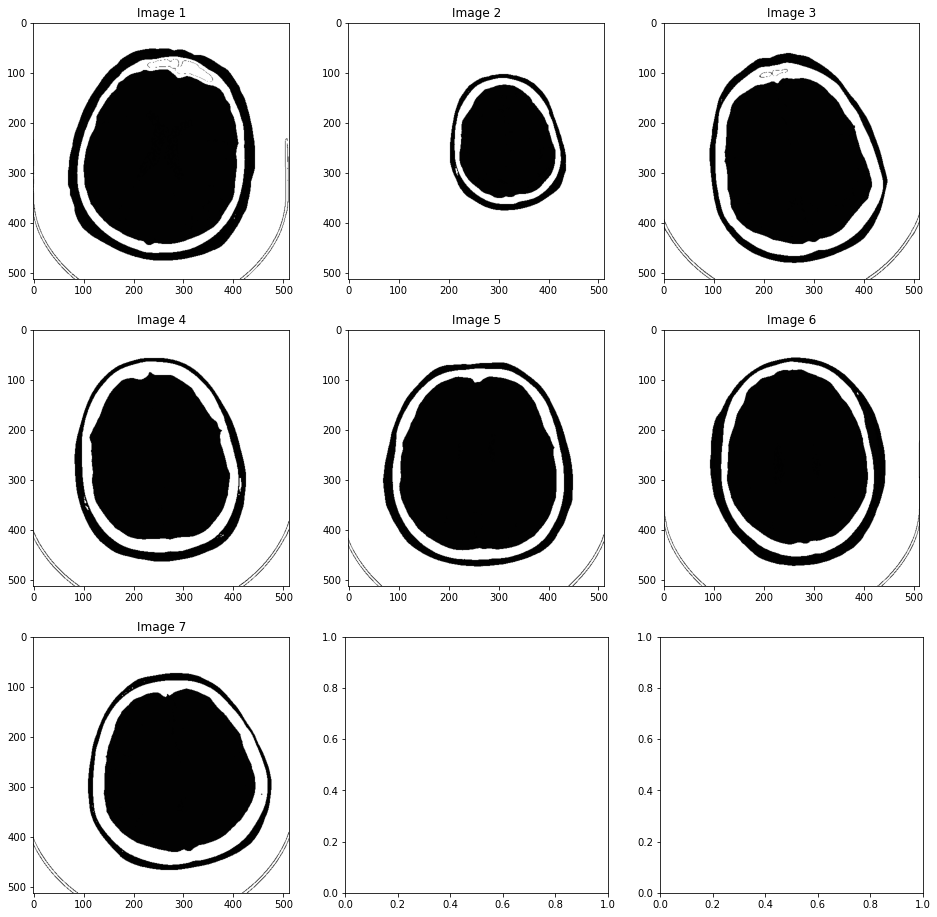

In [12]:
# визуализация
fig, axs = plt.subplots(3, 3, figsize=(16,16))
split = 70
for i in range(7):
    img = images_x[i].copy()[...,split]
    img[img<best_window[0]]=1e6
    img[img>best_window[1]]=1e6
    axs[cy[i],cx[i]].set_title('Image '+str(i+1))
    axs[cy[i],cx[i]].imshow(img, cmap='gray');

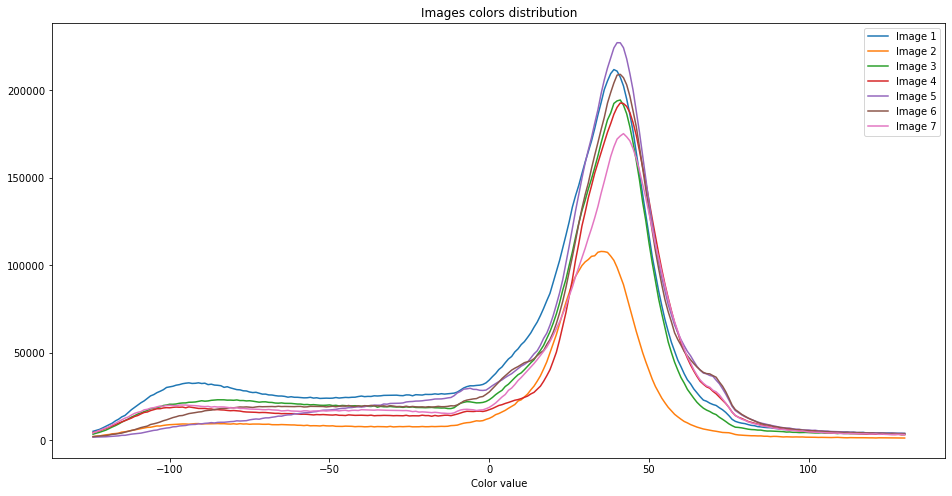

In [13]:
# распределение цветов в диапазоне -124, 130
df[df['Color value'].between(best_window[0], best_window[1])].plot(x="Color value", figsize=(16,8), title = 'Images colors distribution');

Подавляющее большинство необходимой информации на снимке находится внутри указанного цветового диапазона, всё остальное можно попробовать обнулить. При этом нужно учесть, что при повороте снимка появятся дополнительные нулевые значения по краям. Каждый снимок будет обработан следующим образом:
- всем пикселям вне окна [-124, 130] присваиваем значение -124 
- смещаем цвета в область положительных значений прибавкой оффсета в 124;
- сохраняем снимок;
- нормируем снимок к единице и выполняем поворот только на этапе создания датасета.Если сделать это раньше, то сохраняемые файлы снимков из int16 перейдут в float16 и увеличатся примернов 4 раза.

Снимки 2, 5 и 7 могут быть использованы только для обучения модели, поскольку их цветовые распределения выбиваются из общей картины. 

### 1.3 Оценка файлов с разметкой

Необходимо понимание, сбалансированы ли классы разметки.

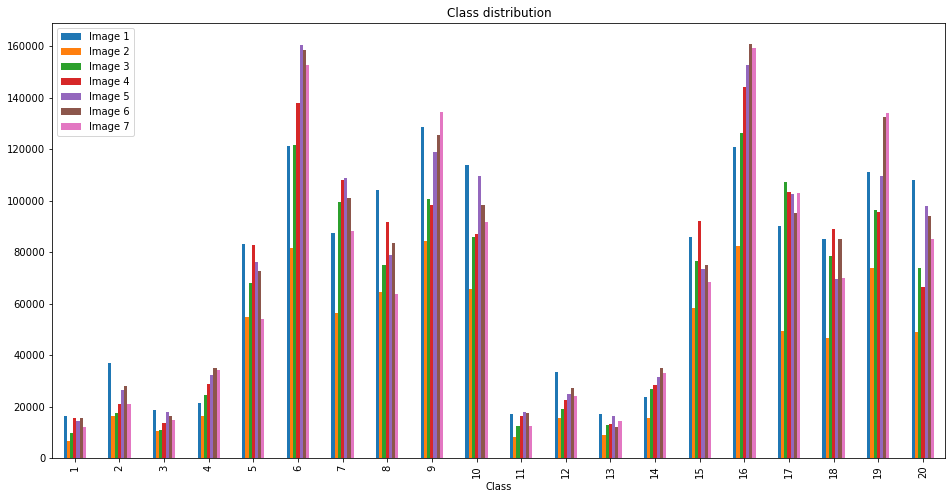

In [14]:
# сбор данных о классах в таблицу и ее визуализация
dfy = pd.DataFrame((np.arange(1,21)), index=(np.arange(1,21)), columns=['Class'])
for i in range(len(images_y)):
    img = np.ravel(images_y[i])
    a = pd.DataFrame((pd.value_counts(img)),columns=['Image '+str(i+1)])
    dfy = dfy.join(a['Image '+str(i+1)], on=dfy.Class, how='left')
dfy.fillna(0, inplace=True)
dfy = dfy.astype('int64')
dfy.plot(x="Class", figsize=(16,8), title = 'Class distribution', kind='bar');

In [15]:
# расчёт дисбаланса классов: более, чем в 10 раз
dfy['Total'] = 0
dfy['Class weight, %'] = 0
dfy['Total'] = dfy[dfy.columns[1:8]].sum(axis=1)
dfy['Class weight, %'] = np.round((dfy[dfy.columns[1:8]].sum(axis=1)/np.sum(dfy[dfy.columns[1:8]].values)*100),2)
print('Maximum class disbalance: %2.0fx.' % np.round(np.max(dfy.Total)/np.min(dfy.Total),0))
dfy

Maximum class disbalance: 10x.


,Class,Image 1,Image 2,Image 3,Image 4,Image 5,Image 6,Image 7,Total,"Class weight, %"
1,1,16374,6792,9867,15368,14230,15561,12177,90369,0.99
2,2,37098,16353,17540,21166,26317,27807,20896,167177,1.82
3,3,18500,10418,10937,13568,17724,16367,14786,102300,1.12
4,4,21211,16453,24568,28776,32120,34882,34103,192113,2.10
5,5,83194,54840,68113,82804,76298,72637,54030,491916,5.37
6,6,121085,81470,121371,137754,160413,158263,152661,933017,10.18
7,7,87536,56257,99320,107837,108885,100960,88279,649074,7.08
8,8,104153,64315,74987,91574,78907,83620,63512,561068,6.12
9,9,128622,84392,100595,98314,118719,125368,134229,790239,8.62
10,10,113752,65730,85882,87106,109526,98261,91507,651764,7.11


Большой дисбаланс классов намекает на использование соответствующей loss-функции.

## 2. Препроцессинг данных

### 2.1 Преобразование снимков, сохранение в папку для датасета

In [94]:
# препроцессинг и сохранение снимков в папку dataset_folder
'''
загрузка
установка в -124 пикселей вне нужного окна цветов
сохранение снимка и разметки в папку dataset_folder
'''
for i in range(7):    
    img_x, img_y = load_and_process_images(os.path.join(source_folder), i+1, None, return_3D_arrays=False)
    img_x_data = sitk.GetArrayFromImage(img_x)
    img_x_data[img_x_data<best_window[0]]=-124
    img_x_data[img_x_data>best_window[1]]=-124
    img_x_data+=124
    img = sitk.GetImageFromArray(img_x_data)
    img.SetOrigin(img_x.GetOrigin())
    img.SetSpacing(img_x.GetSpacing())
    img.SetDirection(img_x.GetDirection())
    sitk.WriteImage(img,os.path.join(dataset_folder, str(i+1)+'.nii'))
    sitk.WriteImage(img_y,os.path.join(dataset_folder, str(i+1)+'-seg.nii'))

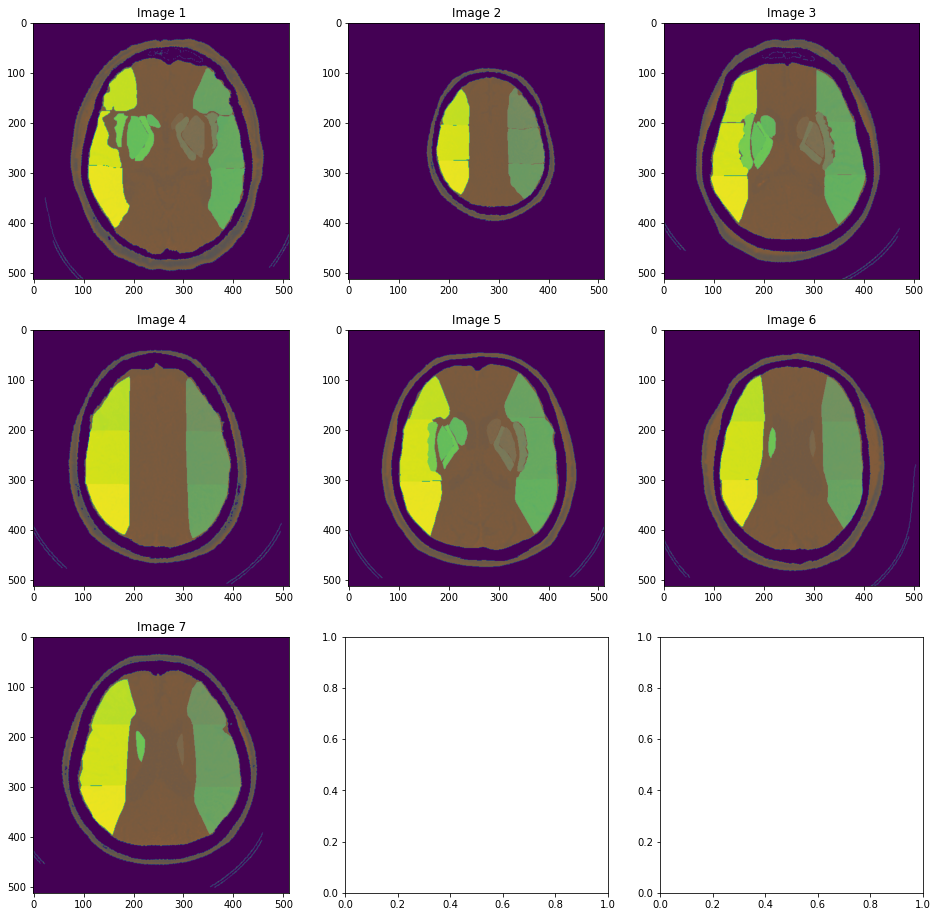

In [11]:
# проверка созданных файлов: загрузка с поворотом снимка относительно разметки; видно улучшение контраста на снимках.
fig, axs = plt.subplots(3, 3, figsize=(16,16))
split = 60
for i in range(7):
    img_x, img_y = load_and_process_images(os.path.join(dataset_folder), i+1, 'X')
    slice_x = img_x[...,split]
    slice_y = img_y[...,split]
    axs[cy[i],cx[i]].set_title('Image '+str(i+1))
    axs[cy[i],cx[i]].imshow(slice_x, alpha=1.0), axs[cy[i],cx[i]].imshow(slice_y, alpha=0.6);

Снимки и разметка готовы к работе: лишние пиксели обращены в нули, динамический диапазон цвета приведен к диапазону 0...1.

Желаемый поворот снимков или разметки определяется параметром *transform_type* функции **load_and_process_images()** на этапе подготовки датасета.

## 3. Выбор loss-функции и метрик

Обоснование выбора - в отчёте, все функции находятся в modules.py.

## 4. Выбор архитектуры сети

Обоснование выбора - в отчёте, сеть находится в папке unet_keras.

##  5. Подготовка датасетoв для трёх сечений

In [6]:
# # создание трёх датасетов для трёх плоскостей будущей сегментации, сохранение в dataset_folder, визуальная проверка для плоскости XY

# for plane in ['XY', 'XZ', 'YZ']:
#     create_dataset(plane, trainval_files, dataset_folder)

# # roughly check if the X-y arrays are correct
# X = load_pkl(os.path.join(dataset_folder, plane+'XY_X.pkl'))
# y1 = load_pkl(os.path.join(dataset_folder, plane+'XY_y1.pkl'))
# y2 = load_pkl(os.path.join(dataset_folder, plane+'XY_y2.pkl'))
# y = np.vstack((y1, y2))
# del y1,y2
# sample_n = 60
# plt.figure(figsize=(8,8))
# plt.imshow(X[sample_n,:,:,0],alpha=0.8),plt.imshow(np.sum(y[sample_n,:,:,:],axis=2),alpha=0.6)
# plt.show()

## 6. Обучение сети и сегментация снимков в плоскости XY

### 6.1 Загрузка и индексирование датасета

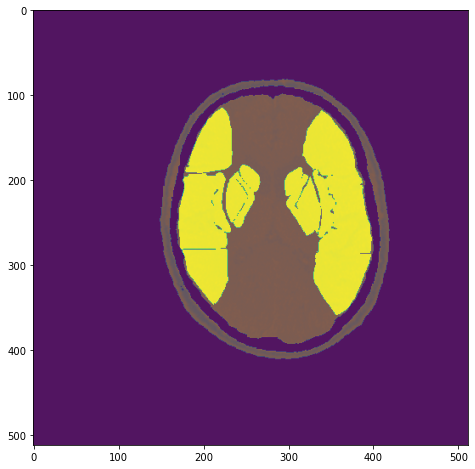

In [3]:
# загрузка и визуальная проверка данных

plane = 'XY'
X = load_pkl(os.path.join(dataset_folder, plane+'_X.pkl'))
y1 = load_pkl(os.path.join(dataset_folder, plane+'_y1.pkl'))
y2 = load_pkl(os.path.join(dataset_folder, plane+'_y2.pkl'))
y = np.vstack((y1, y2))
del y1,y2

# roughly check if the X-y arrays are correct
sample_n = 60
plt.figure(figsize=(8,8))
plt.imshow(X[sample_n,:,:,0],alpha=0.8),plt.imshow(np.sum(y[sample_n,:,:,:],axis=2),alpha=0.6)
plt.show()

In [4]:
# создание train/val индексов
trainval_split=.8

all_indices = np.arange(X.shape[0])
seed(42)
shuffle(all_indices)
n_indices = len(all_indices)
train_part = int(n_indices*trainval_split)
train_indices = all_indices[:train_part]
val_indices = all_indices[train_part:]
len(train_indices), len(val_indices)

(614, 154)

### 6.2 Загрузка модели

Для начала параметры loss-функции установлены {alpha=0.5, beta=0.5} - это стандартный Dice loss, dropout=0.2. Полученный результат используем как бейзлайн.

Размер батча выбран равным 4 - это предельное значение, которое помещается в памяти компьютера.

In [19]:
model = load_2d_unet(input_shape=(512,512,1), num_labels=20, noise=0.0, dropout=0.2, init_filter=32)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         gaussian_noise[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
______________________________________________________________________________________________

### 6.3 Обучение

In [23]:
# запуск
n_epochs   = 300
batch_size = 4
lr         = 1e-3

model.compile(optimizer=Adam(learning_rate=lr), loss=tversky_loss, metrics=[cce(), 'mse'])

# data generators
train_generator = BatchGenerator(X, y, train_indices, batch_size=batch_size)
val_generator   = BatchGenerator(X, y, val_indices, batch_size=batch_size)

# callbacks
early_stop = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True, verbose=1)
lr_reduce  = ReduceLROnPlateau(monitor='loss', min_lr=0, cooldown=3, factor=0.1, patience=3, verbose=1, mode='min')
m_save = ModelCheckpoint(str(Path(os.getcwd(), plane+'_base_temp_weights.h5')), monitor='loss', 
                         verbose=0, save_best_only=True, save_weights_only=True, mode='min', period=1)

# train model
history = model.fit_generator(generator=train_generator, validation_data=val_generator, 
                             epochs=n_epochs, callbacks=[early_stop, lr_reduce, m_save],                              
                             verbose=1, workers=0, use_multiprocessing=False)

model.save_weights(str(Path(os.getcwd(), plane+'_base_weights.h5')))
print('Done.')
print("Val_loss: %2.4e" % np.min(history.history['val_loss']))

Epoch 1/300
153/153 [==============================] - 124s 813ms/step - loss: 19.7445 - categorical_crossentropy: 0.0972 - mse: 0.1842 - val_loss: 19.8135 - val_categorical_crossentropy: 0.1291 - val_mse: 0.3772
Epoch 2/300
153/153 [==============================] - 118s 773ms/step - loss: 18.6242 - categorical_crossentropy: 0.0921 - mse: 0.0495 - val_loss: 19.3949 - val_categorical_crossentropy: 0.1290 - val_mse: 0.2855
Epoch 3/300
153/153 [==============================] - 118s 773ms/step - loss: 17.2226 - categorical_crossentropy: 0.0960 - mse: 0.0227 - val_loss: 18.1823 - val_categorical_crossentropy: 0.1403 - val_mse: 0.0294
Epoch 4/300
153/153 [==============================] - 118s 772ms/step - loss: 16.5135 - categorical_crossentropy: 0.0943 - mse: 0.0160 - val_loss: 17.9012 - val_categorical_crossentropy: 0.1860 - val_mse: 0.0163
Epoch 5/300
153/153 [==============================] - 124s 812ms/step - loss: 16.0062 - categorical_crossentropy: 0.0892 - mse: 0.0145 - val_loss: 

Epoch 39/300
153/153 [==============================] - 124s 811ms/step - loss: 12.7722 - categorical_crossentropy: 0.0334 - mse: 0.0013 - val_loss: 12.5527 - val_categorical_crossentropy: 0.0667 - val_mse: 0.0020
Epoch 40/300
153/153 [==============================] - 122s 800ms/step - loss: 12.8158 - categorical_crossentropy: 0.0333 - mse: 0.0013 - val_loss: 12.5401 - val_categorical_crossentropy: 0.0696 - val_mse: 0.0019
Epoch 41/300
153/153 [==============================] - 118s 772ms/step - loss: 12.7523 - categorical_crossentropy: 0.0321 - mse: 0.0013 - val_loss: 12.8613 - val_categorical_crossentropy: 0.0877 - val_mse: 0.0021
Epoch 42/300
153/153 [==============================] - 118s 771ms/step - loss: 12.7415 - categorical_crossentropy: 0.0330 - mse: 0.0012 - val_loss: 15.7427 - val_categorical_crossentropy: 0.1419 - val_mse: 0.0016
Epoch 43/300
153/153 [==============================] - 123s 805ms/step - loss: 12.6932 - categorical_crossentropy: 0.0310 - mse: 0.0012 - val_l

Epoch 112/300
153/153 [==============================] - 125s 818ms/step - loss: 11.7198 - categorical_crossentropy: 0.0070 - mse: 3.1986e-04 - val_loss: 11.4637 - val_categorical_crossentropy: 0.0523 - val_mse: 8.0184e-04
Epoch 113/300
153/153 [==============================] - 126s 822ms/step - loss: 11.7198 - categorical_crossentropy: 0.0069 - mse: 3.2000e-04 - val_loss: 11.4492 - val_categorical_crossentropy: 0.0529 - val_mse: 7.9500e-04
Epoch 114/300
153/153 [==============================] - 125s 819ms/step - loss: 11.7137 - categorical_crossentropy: 0.0067 - mse: 3.0689e-04 - val_loss: 11.4640 - val_categorical_crossentropy: 0.0537 - val_mse: 7.9109e-04
Epoch 115/300
153/153 [==============================] - 125s 816ms/step - loss: 11.7150 - categorical_crossentropy: 0.0068 - mse: 3.1815e-04 - val_loss: 11.4530 - val_categorical_crossentropy: 0.0523 - val_mse: 7.7450e-04
Epoch 116/300
153/153 [==============================] - 126s 825ms/step - loss: 11.7131 - categorical_cross

Epoch 148/300
153/153 [==============================] - 125s 818ms/step - loss: 11.6446 - categorical_crossentropy: 0.0056 - mse: 2.9209e-04 - val_loss: 11.4568 - val_categorical_crossentropy: 0.0538 - val_mse: 8.1201e-04
Epoch 149/300
153/153 [==============================] - 126s 821ms/step - loss: 11.6439 - categorical_crossentropy: 0.0058 - mse: 2.9788e-04 - val_loss: 11.4580 - val_categorical_crossentropy: 0.0537 - val_mse: 8.1408e-04
Epoch 150/300
153/153 [==============================] - 126s 821ms/step - loss: 11.6413 - categorical_crossentropy: 0.0056 - mse: 2.9105e-04 - val_loss: 11.4541 - val_categorical_crossentropy: 0.0533 - val_mse: 8.1481e-04
Epoch 151/300
153/153 [==============================] - 126s 826ms/step - loss: 11.6412 - categorical_crossentropy: 0.0056 - mse: 2.8945e-04 - val_loss: 11.4543 - val_categorical_crossentropy: 0.0534 - val_mse: 8.1291e-04
Epoch 152/300
153/153 [==============================] - 126s 826ms/step - loss: 11.6404 - categorical_cross

153/153 [==============================] - 124s 810ms/step - loss: 11.6321 - categorical_crossentropy: 0.0056 - mse: 2.9433e-04 - val_loss: 11.4562 - val_categorical_crossentropy: 0.0535 - val_mse: 8.1176e-04
Epoch 213/300
152/153 [============================>.] - ETA: 0s - loss: 11.6847 - categorical_crossentropy: 0.0055 - mse: 2.9360e-04
Epoch 00213: ReduceLROnPlateau reducing learning rate to 1.0000001095066122e-16.
153/153 [==============================] - 124s 810ms/step - loss: 11.6330 - categorical_crossentropy: 0.0055 - mse: 2.9297e-04 - val_loss: 11.4562 - val_categorical_crossentropy: 0.0535 - val_mse: 8.1185e-04
Epoch 214/300
153/153 [==============================] - 124s 810ms/step - loss: 11.6330 - categorical_crossentropy: 0.0055 - mse: 2.8940e-04 - val_loss: 11.4563 - val_categorical_crossentropy: 0.0535 - val_mse: 8.1170e-04
Epoch 215/300
153/153 [==============================] - 124s 810ms/step - loss: 11.6308 - categorical_crossentropy: 0.0055 - mse: 2.9176e-04 - 

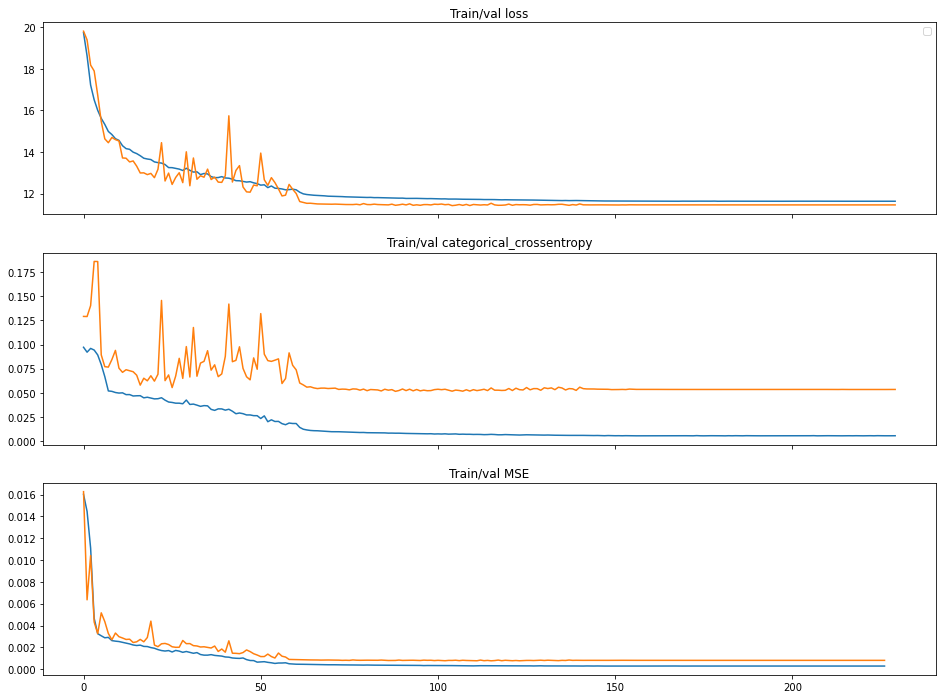

In [91]:
# пост-визуализация процесса
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16,12), sharex=True)
ax1.set_title('Train/val loss')
ax1.plot(history.history['loss']), ax1.plot(history.history['val_loss']);
ax2.set_title('Train/val categorical_crossentropy')
ax2.plot(history.history['categorical_crossentropy']), ax2.plot(history.history['val_categorical_crossentropy']);
ax3.set_title('Train/val MSE')
ax3.plot(history.history['mse'][3:]), ax3.plot(history.history['val_mse'][3:]);

In [45]:
# сохранение истории
save_pkl(history.history, os.path.join(plane+'_base_history.pkl'))

### 6.4 Тестовая сегментация

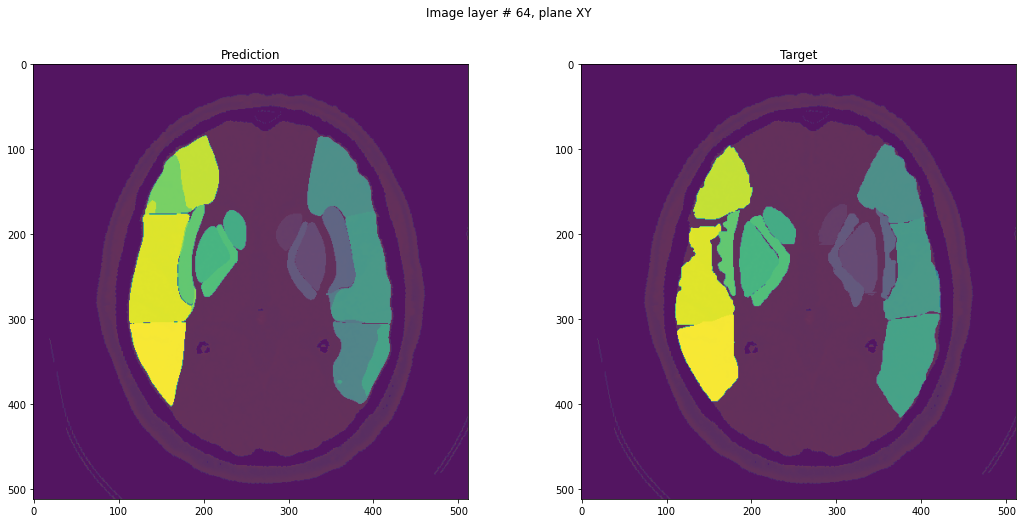

In [3]:
plane = 'XY'

# загрузка модели и весов
model = load_2d_unet(input_shape=(512,512,1), num_labels=20, noise=0.0, dropout=0.0, init_filter=32)
model.compile(optimizer=Adam(learning_rate=0), loss=tversky_loss, metrics=[cce(), 'mse'])
model.load_weights(str(Path(os.getcwd(),plane+'_base_weights.h5')))

# сегментация тестового файла
X_test, y_test = load_and_process_images(os.path.join(dataset_folder), predict_file[0], 'X')
X_test=X_test/np.max(X_test)
X_test = np.moveaxis(X_test, 2, 0)
y_pred = np.zeros(X_test.shape+(20,), dtype='bool')
X_test = np.expand_dims(X_test, 3)
test_generator  = BatchGenerator(X_test, y_test, np.arange(X_test.shape[0]), batch_size=1, shuffle=False)
y_pred = model.predict(test_generator)
y_pred[y_pred<threshold]=0
res = np.argmax(y_pred, axis=3)+1
y_pred=np.sum(y_pred, axis=3)
y_pred[y_pred!=0]=1
y_pred = y_pred*res
y_pred = y_pred.astype('int16')
X_test = X_test[...,0]
X_test = np.moveaxis(X_test, 0, -1)
y_pred = np.moveaxis(y_pred, 0, -1)

# визуализация результата
sample_n = 64
target_slice = y_test[...,sample_n]
pred_slice = y_pred[...,sample_n]
X_slice = X_test[...,sample_n]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8));
fig.suptitle('Image layer # %i, plane %s' % (sample_n, plane))
ax1.set_title('Prediction')
ax2.set_title('Target')
ax1.imshow(X_slice, alpha=.6), ax1.imshow(pred_slice, alpha=.8);
ax2.imshow(X_slice, alpha=.6), ax2.imshow(target_slice, alpha=.8);

### 6.5 Сохранение файла сегментации

In [21]:
_, y_true = load_and_process_images(os.path.join(dataset_folder), predict_file[0], None, return_3D_arrays=False)
print('Go to img shape:', np.moveaxis(y_pred, (0,1), (1,2)).shape)
img = sitk.GetImageFromArray(np.moveaxis(y_pred, (0,1), (1,2)))
img.SetOrigin(y_true.GetOrigin())
img.SetSpacing(y_true.GetSpacing())
img.SetDirection(y_true.GetDirection())
sitk.WriteImage(img,os.path.join(dataset_folder, str(predict_file[0])+'-seg-predicted.nii'))

Go to img shape: (102, 512, 512)


### 6.6 Оценка метрик сегментации в плоскости XY

Расчет сегментаций для всех снимков и вычисление метрик.

Для удобства визуализации результаты сохранены в таблицы.

In [5]:
# расчет метрик для всех снимков
iou_df = pd.DataFrame(index=np.arange(1, n_output_channels+1))
fp_df = pd.DataFrame(index=np.arange(n_output_channels+1))
fn_df = pd.DataFrame(index=np.arange(n_output_channels+1))
misclass_df = pd.DataFrame(index=np.arange(n_output_channels+1))
totals_df = pd.DataFrame(index=['IoU'])


for i in range(7):    
    print('Image %s...' % str(i+1))    
    X_test, y_test = load_and_process_images(os.path.join(dataset_folder), i+1, 'X')

    X_test=X_test/np.max(X_test)

    X_test = np.moveaxis(X_test, 2, 0)
    y_pred = np.zeros(X_test.shape+(20,), dtype='bool')
    X_test = np.expand_dims(X_test, 3)

    test_generator  = BatchGenerator(X_test, X_test, np.arange(X_test.shape[0]), batch_size=1, shuffle=False)

    y_pred = model.predict(test_generator)
    y_pred[y_pred<threshold]=0
    res = np.argmax(y_pred, axis=3)+1
    y_pred=np.sum(y_pred, axis=3)
    y_pred[y_pred!=0]=1
    y_pred = y_pred*res
    y_pred = y_pred.astype('int16')    
    X_test = X_test[...,0]
    X_test = np.moveaxis(X_test, 0, -1)
    y_pred = np.moveaxis(y_pred, 0, -1)
    
    m = Metrics(y_test, y_pred)
    
    iou_df['Image '+str(i+1)]=m.classIoU
    fp_df['Image '+str(i+1)]=m.FP
    fn_df['Image '+str(i+1)]=m.FN
    misclass_df['Image '+str(i+1)]=m.misclass_rate
    totals_df['Image '+str(i+1)]=0.
    totals_df['Image '+str(i+1)][0]=m.IoU
    
fpfn_df = fp_df/fn_df

Image 1...
Image 2...
Image 3...
Image 4...
Image 5...
Image 6...
Image 7...


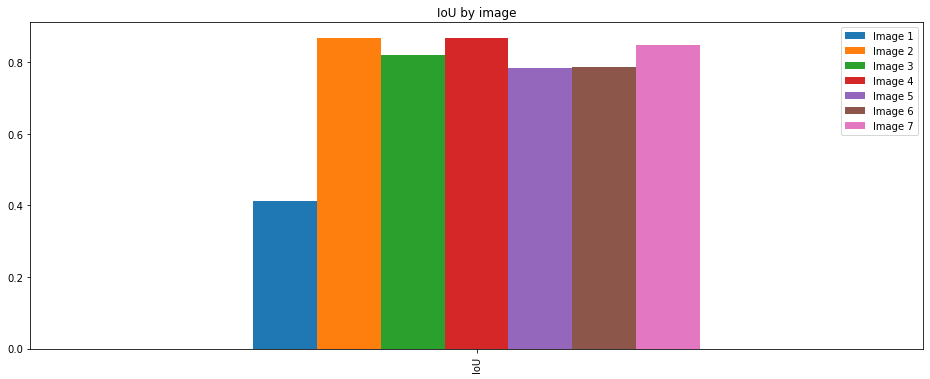

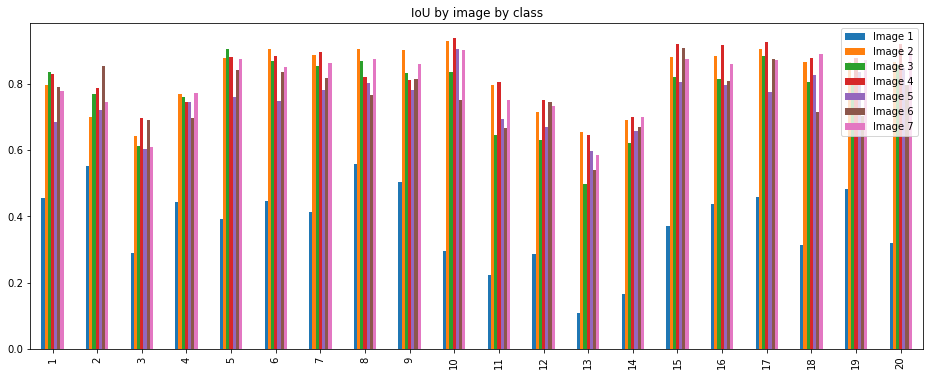

In [6]:
# визуализация метрик
totals_df[totals_df.index=='IoU'].plot(kind='bar', title = 'IoU by image', figsize=(16,6));
iou_df.plot(title = 'IoU by image by class', kind='bar',figsize=(16,6));

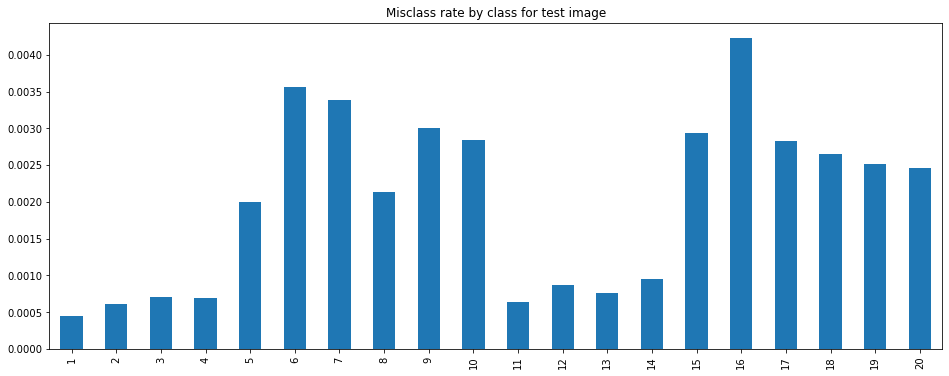

In [7]:
misclass_df['Image 1'][1:].plot(kind='bar', title = 'Misclass rate by class for test image',figsize=(16,6));

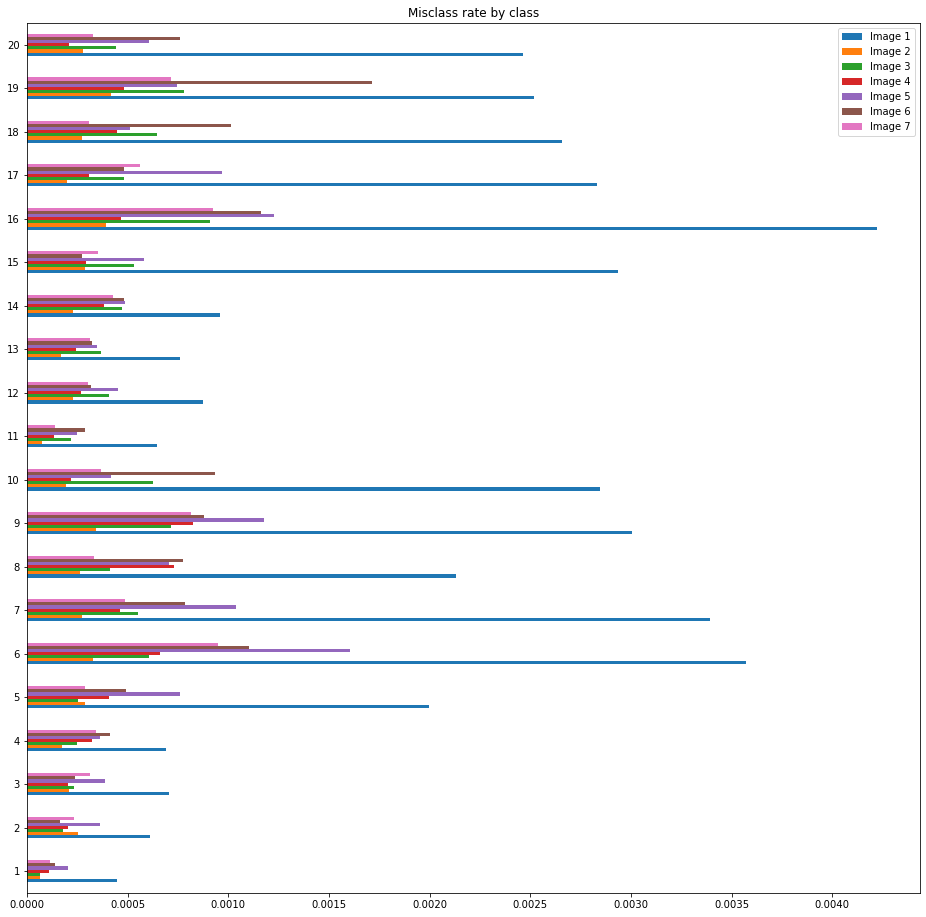

In [8]:
misclass_df[1:].plot(kind='barh', title = 'Misclass rate by class',figsize=(16,16));

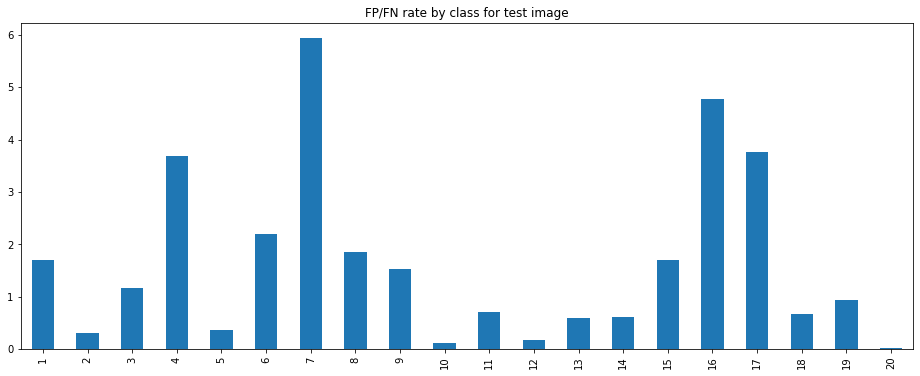

In [9]:
(fpfn_df['Image 1'])[1:].plot(kind='bar', title = 'FP/FN rate by class for test image',figsize=(16,6));

**Baseline значения метрик:**

In [10]:
# сохранение baseline
IoU_baseline = totals_df.iloc[0,0]
FPFN_rates_baseline = fpfn_df.iloc[1:,0].values
test_img_misclass_baseline = misclass_df['Image 1'][1:].values
print('Test image baseline:\nIoU %2.2f,\nFP/FN rates %s\nTest image misclassification rate_baseline:\n%s' % (IoU_baseline, FPFN_rates_baseline, test_img_misclass_baseline))

Test image baseline:
IoU 0.41,
FP/FN rates [1.70202 0.30919 1.17027 3.68475 0.37258 2.20041 5.93092 1.84582 1.52233
 0.11056 0.71488 0.17497 0.598   0.61844 1.69429 4.78197 3.76452 0.66899
 0.92979 0.02572]
Test image misclassification rate_baseline:
[0.00045 0.00061 0.0007  0.00069 0.002   0.00357 0.00339 0.00213 0.003
 0.00285 0.00065 0.00087 0.00076 0.00096 0.00294 0.00422 0.00283 0.00265
 0.00252 0.00246]


Наглядны следующие вещи: 
- IoU на тестовом снимке гораздо хуже, чем на обучающих, что говорит об оверфите - нужно увеличить Dropout rate и, возможно, добавить шума на входе;
- ошибка определения класса хоть и невелика для всего датасета, но для тестового снимка она в разы превосходит все остальные;
- есть небольшой перевес в сторону FP пикселей, и можно попробовать подобрать коэффициенты alpha и beta в loss-функции, чтобы выровнять это соотношение.

### 6.7 Повторное обучение с подобранными гиперпараметрами

Повторное обучение сети с параметрами alpha=0.85, beta=0.15, dropout=0.3

#### Обучение

In [7]:
plane = 'XY'
model = load_2d_unet(input_shape=(512,512,1), num_labels=20, noise=0.0, dropout=0.3, init_filter=32)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
gaussian_noise_2 (GaussianNoise (None, 512, 512, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 512, 512, 32) 320         gaussian_noise_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 512, 512, 32) 128         conv2d_46[0][0]                  
____________________________________________________________________________________________

In [8]:
n_epochs   = 300
batch_size = 4
lr         = 1e-3

model.compile(optimizer=Adam(learning_rate=lr), loss=tversky_loss, metrics=[cce(), 'mse'])

# data generators
train_generator = BatchGenerator(X, y, train_indices, batch_size=batch_size)
val_generator   = BatchGenerator(X, y, val_indices, batch_size=batch_size)

# callbacks
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=1)
lr_reduce  = ReduceLROnPlateau(monitor='loss', min_lr=0, cooldown=3, factor=0.1, patience=3, verbose=1, mode='min')
m_save = ModelCheckpoint(str(Path(os.getcwd(), plane+'_a85b15d3_temp_weights.h5')), monitor='loss', 
                         verbose=0, save_best_only=True, save_weights_only=True, mode='min', period=1)

# train model
history = model.fit_generator(generator=train_generator, validation_data=val_generator, 
                             epochs=n_epochs, callbacks=[early_stop, lr_reduce, m_save],                              
                             verbose=1, workers=0, use_multiprocessing=False)

model.save_weights(str(Path(os.getcwd(), plane+'_a85b15d3_weights.h5')))
print('Done.')
print("Val_loss: %2.4e" % np.min(history.history['val_loss']))

Epoch 1/300
153/153 [==============================] - 126s 823ms/step - loss: 19.8571 - categorical_crossentropy: 0.0956 - mse: 0.1546 - val_loss: 19.8906 - val_categorical_crossentropy: 0.1572 - val_mse: 0.3338
Epoch 2/300
153/153 [==============================] - 121s 793ms/step - loss: 19.0421 - categorical_crossentropy: 0.0978 - mse: 0.0446 - val_loss: 19.9756 - val_categorical_crossentropy: 0.5459 - val_mse: 0.1058
Epoch 3/300
153/153 [==============================] - 122s 796ms/step - loss: 17.8124 - categorical_crossentropy: 0.1286 - mse: 0.0210 - val_loss: 19.1599 - val_categorical_crossentropy: 0.2770 - val_mse: 0.0364
Epoch 4/300
153/153 [==============================] - 121s 792ms/step - loss: 17.3011 - categorical_crossentropy: 0.1378 - mse: 0.0168 - val_loss: 18.2450 - val_categorical_crossentropy: 0.1565 - val_mse: 0.0282
Epoch 5/300
153/153 [==============================] - 122s 800ms/step - loss: 16.8402 - categorical_crossentropy: 0.1430 - mse: 0.0107 - val_loss: 

Epoch 39/300
153/153 [==============================] - 118s 773ms/step - loss: 12.3362 - categorical_crossentropy: 0.0468 - mse: 9.1963e-04 - val_loss: 12.8826 - val_categorical_crossentropy: 0.0924 - val_mse: 0.0012
Epoch 40/300
153/153 [==============================] - 117s 763ms/step - loss: 12.4567 - categorical_crossentropy: 0.0521 - mse: 9.8336e-04 - val_loss: 15.1497 - val_categorical_crossentropy: 0.1362 - val_mse: 0.0016
Epoch 41/300
153/153 [==============================] - 120s 786ms/step - loss: 12.3920 - categorical_crossentropy: 0.0502 - mse: 9.2723e-04 - val_loss: 16.0655 - val_categorical_crossentropy: 0.1964 - val_mse: 0.0021
Epoch 42/300
152/153 [============================>.] - ETA: 0s - loss: 12.3816 - categorical_crossentropy: 0.0503 - mse: 8.8462e-04
Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
153/153 [==============================] - 120s 786ms/step - loss: 12.4314 - categorical_crossentropy: 0.0500 - mse: 8.8045e-04 - va

Epoch 76/300
153/153 [==============================] - 129s 845ms/step - loss: 11.8580 - categorical_crossentropy: 0.0245 - mse: 5.8151e-04 - val_loss: 12.3588 - val_categorical_crossentropy: 0.0675 - val_mse: 9.1374e-04
Epoch 77/300
153/153 [==============================] - 129s 845ms/step - loss: 11.8523 - categorical_crossentropy: 0.0238 - mse: 5.8155e-04 - val_loss: 12.7074 - val_categorical_crossentropy: 0.0821 - val_mse: 0.0012
Epoch 78/300
153/153 [==============================] - 129s 845ms/step - loss: 11.8494 - categorical_crossentropy: 0.0237 - mse: 5.9788e-04 - val_loss: 12.5588 - val_categorical_crossentropy: 0.0814 - val_mse: 0.0011
Epoch 79/300
153/153 [==============================] - 128s 836ms/step - loss: 11.8523 - categorical_crossentropy: 0.0238 - mse: 5.8569e-04 - val_loss: 12.6818 - val_categorical_crossentropy: 0.0843 - val_mse: 0.0011
Epoch 80/300
153/153 [==============================] - 129s 844ms/step - loss: 11.8483 - categorical_crossentropy: 0.0235 -

153/153 [==============================] - 124s 810ms/step - loss: 11.7180 - categorical_crossentropy: 0.0138 - mse: 4.7923e-04 - val_loss: 12.4869 - val_categorical_crossentropy: 0.0719 - val_mse: 0.0010
Epoch 149/300
153/153 [==============================] - 124s 810ms/step - loss: 11.7179 - categorical_crossentropy: 0.0139 - mse: 4.8032e-04 - val_loss: 12.4878 - val_categorical_crossentropy: 0.0719 - val_mse: 0.0010
Epoch 150/300
153/153 [==============================] - 125s 819ms/step - loss: 11.7163 - categorical_crossentropy: 0.0139 - mse: 4.8008e-04 - val_loss: 12.4858 - val_categorical_crossentropy: 0.0718 - val_mse: 0.0010
Epoch 151/300
153/153 [==============================] - 125s 815ms/step - loss: 11.7181 - categorical_crossentropy: 0.0141 - mse: 4.8441e-04 - val_loss: 12.4855 - val_categorical_crossentropy: 0.0719 - val_mse: 0.0010
Epoch 152/300
153/153 [==============================] - 125s 815ms/step - loss: 11.7198 - categorical_crossentropy: 0.0141 - mse: 4.8652e

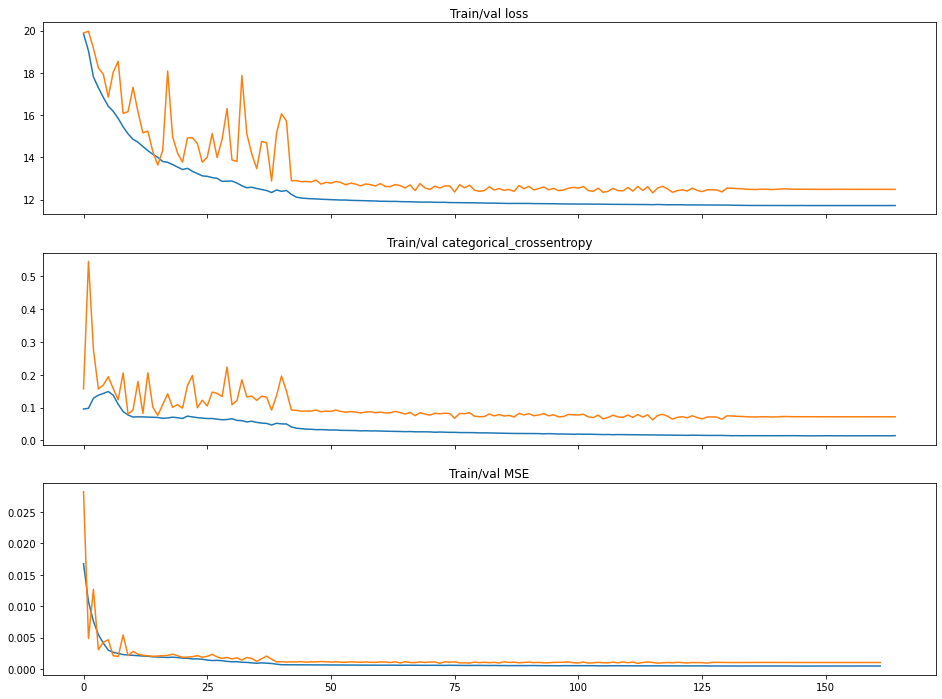

In [9]:
# пост-визуализация процесса
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16,12), sharex=True)
ax1.set_title('Train/val loss')
ax1.plot(history.history['loss']), ax1.plot(history.history['val_loss']);
ax2.set_title('Train/val categorical_crossentropy')
ax2.plot(history.history['categorical_crossentropy']), ax2.plot(history.history['val_categorical_crossentropy']);
ax3.set_title('Train/val MSE')
ax3.plot(history.history['mse'][3:]), ax3.plot(history.history['val_mse'][3:]);

In [10]:
# сохранение истории
save_pkl(history.history, os.path.join(plane+'_a85b15d3_history.pkl'))

#### Визуализация тестового снимка и расчет метрик

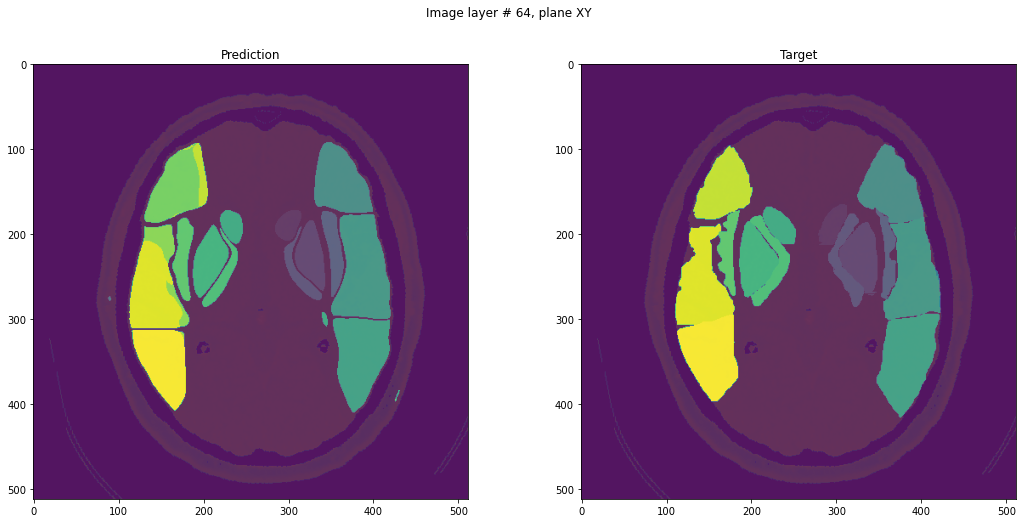

In [11]:
plane = 'XY'

# загрузка модели и весов
model = load_2d_unet(input_shape=(512,512,1), num_labels=20, noise=0.0, dropout=0.0, init_filter=32)
model.compile(optimizer=Adam(learning_rate=0), loss=tversky_loss, metrics=[cce(), 'mse'])
model.load_weights(str(Path(os.getcwd(),plane+'_a85b15d3_weights.h5')))

# сегментация тестового файла
X_test, y_test = load_and_process_images(os.path.join(dataset_folder), predict_file[0], 'X')
X_test=X_test/np.max(X_test)
X_test = np.moveaxis(X_test, 2, 0)
y_pred = np.zeros(X_test.shape+(20,), dtype='bool')
X_test = np.expand_dims(X_test, 3)
test_generator  = BatchGenerator(X_test, y_test, np.arange(X_test.shape[0]), batch_size=1, shuffle=False)
y_pred = model.predict(test_generator)
y_pred[y_pred<threshold]=0
res = np.argmax(y_pred, axis=3)+1
y_pred=np.sum(y_pred, axis=3)
y_pred[y_pred!=0]=1
y_pred = y_pred*res
y_pred = y_pred.astype('int16')
X_test = X_test[...,0]
X_test = np.moveaxis(X_test, 0, -1)
y_pred = np.moveaxis(y_pred, 0, -1)

# визуализация результата
sample_n = 64
target_slice = y_test[...,sample_n]
pred_slice = y_pred[...,sample_n]
X_slice = X_test[...,sample_n]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8));
fig.suptitle('Image layer # %i, plane %s' % (sample_n, plane))
ax1.set_title('Prediction')
ax2.set_title('Target')
ax1.imshow(X_slice, alpha=.6), ax1.imshow(pred_slice, alpha=.8);
ax2.imshow(X_slice, alpha=.6), ax2.imshow(target_slice, alpha=.8);

In [4]:
# сохранение сегментации
_, y_true = load_and_process_images(os.path.join(dataset_folder), predict_file[0], None, return_3D_arrays=False)
print('Go to img shape:', np.moveaxis(y_pred, (0,1), (1,2)).shape)
img = sitk.GetImageFromArray(np.moveaxis(y_pred, (0,1), (1,2)))
img.SetOrigin(y_true.GetOrigin())
img.SetSpacing(y_true.GetSpacing())
img.SetDirection(y_true.GetDirection())
sitk.WriteImage(img,os.path.join(str(predict_file[0])+'-'+plane+'-seg-predicted.nii'))

Go to img shape: (116, 512, 512)


In [3]:
plane = 'XY'

# загрузка модели и весов
model = load_2d_unet(input_shape=(512,512,1), num_labels=20, noise=0.0, dropout=0.0, init_filter=32)
model.compile(optimizer=Adam(learning_rate=0), loss=tversky_loss, metrics=[cce(), 'mse'])
model.load_weights(str(Path(os.getcwd(),plane+'_a85b15d3_weights.h5')))

# расчет метрик для всех снимков
iou_df = pd.DataFrame(index=np.arange(1, n_output_channels+1))
fp_df = pd.DataFrame(index=np.arange(n_output_channels+1))
fn_df = pd.DataFrame(index=np.arange(n_output_channels+1))
misclass_df = pd.DataFrame(index=np.arange(n_output_channels+1))
totals_df = pd.DataFrame(index=['IoU'])

for i in range(7):    
    
    print('Image %s...' % str(i+1))    
    
    X_test, y_test = load_and_process_images(os.path.join(dataset_folder), i+1, 'X')

    X_test=X_test/np.max(X_test)

    X_test = np.moveaxis(X_test, 2, 0)
    y_pred = np.zeros(X_test.shape+(20,), dtype='bool')
    X_test = np.expand_dims(X_test, 3)

    test_generator  = BatchGenerator(X_test, X_test, np.arange(X_test.shape[0]), batch_size=1, shuffle=False)

    y_pred = model.predict(test_generator)
    y_pred[y_pred<threshold]=0
    res = np.argmax(y_pred, axis=3)+1
    y_pred=np.sum(y_pred, axis=3)
    y_pred[y_pred!=0]=1
    y_pred = y_pred*res
    y_pred = y_pred.astype('int16')    
    X_test = X_test[...,0]
    X_test = np.moveaxis(X_test, 0, -1)
    y_pred = np.moveaxis(y_pred, 0, -1)
    
    m = Metrics(y_test, y_pred)
    
    iou_df['Image '+str(i+1)]=m.classIoU
    fp_df['Image '+str(i+1)]=m.FP
    fn_df['Image '+str(i+1)]=m.FN
    misclass_df['Image '+str(i+1)]=m.misclass_rate
    totals_df['Image '+str(i+1)]=0.
    totals_df['Image '+str(i+1)][0]=m.IoU
    
fpfn_df = fp_df/fn_df
IoU_XY = iou_df.iloc[0,0]
FPFN_rates_XY = fpfn_df.iloc[1:,0].values
test_img_misclass_XY = misclass_df['Image 1'][1:].values

Image 1...
Image 2...
Image 3...
Image 4...
Image 5...
Image 6...
Image 7...


#### Визуализация метрик

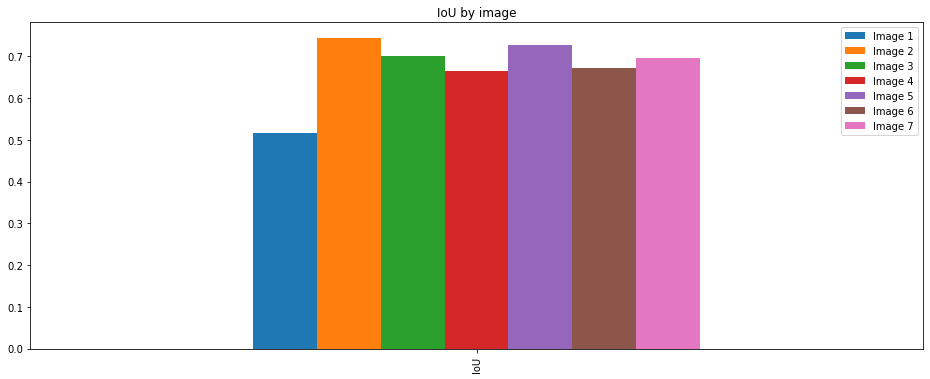

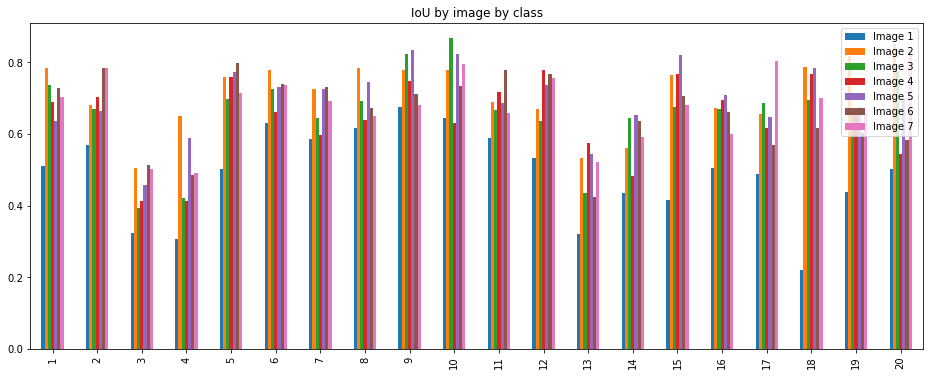

In [9]:
# визуализация метрик
from baseline_metrics import *
totals_df[totals_df.index=='IoU'].plot(kind='bar', title = 'IoU by image', figsize=(16,6));
iou_df.plot(title = 'IoU by image by class', kind='bar',figsize=(16,6));

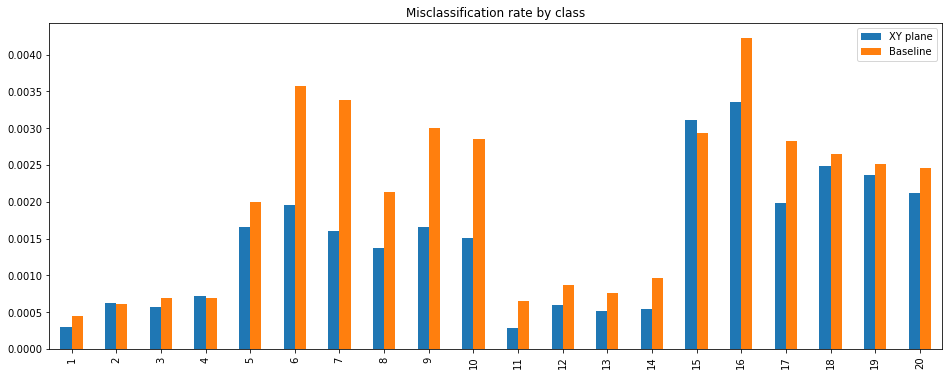

In [11]:
pd.DataFrame({'XY plane': test_img_misclass_XY,'Baseline':test_img_misclass_baseline},index=range(1,21)).plot(kind='bar', title='Misclassification rate by class', figsize=(16,6));

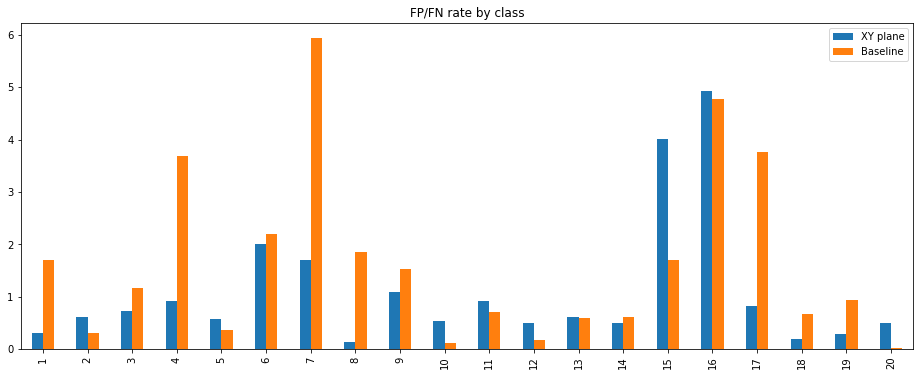

In [12]:
pd.DataFrame({'XY plane': FPFN_rates_XY,'Baseline':FPFN_rates_baseline},index=range(1,21)).plot(kind='bar', title='FP/FN rate by class', figsize=(16,6));

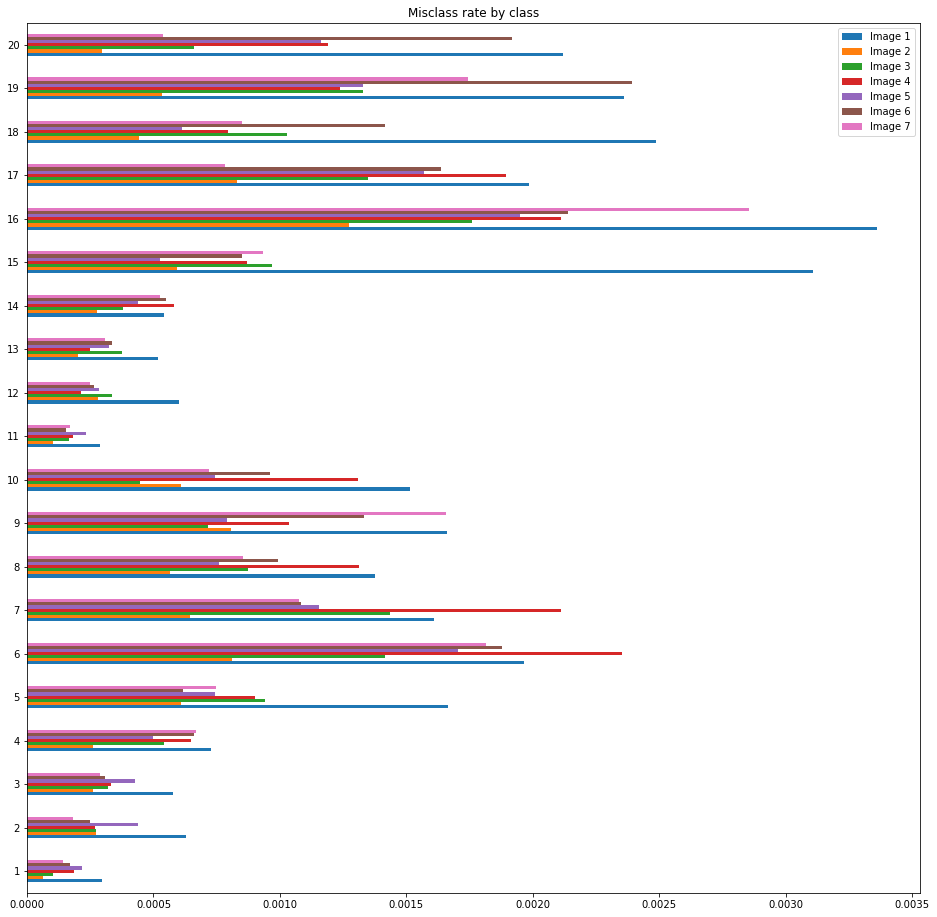

In [13]:
misclass_df[1:].plot(kind='barh', title = 'Misclass rate by class',figsize=(16,16));

In [14]:
# сравнение с baseline
print('For test image:\n\nIoU:: baseline %2.2f, improved %2.2f\n' % (IoU_baseline, IoU_XY))
print('Variance of FP/FN rates between classes:: baseline: %2.2f, improved: %2.2f' % (np.var(FPFN_rates_baseline), np.var(FPFN_rates_XY)))
print('Mean of FP/FN rates between classes::     baseline: %2.2f, improved: %2.2f\n' % (np.mean(FPFN_rates_baseline), np.mean(FPFN_rates_XY)))
print('Variance of misclassification rates between classes, *1e-6:: baseline: %2.2f, improved: %2.2f' % (np.var(test_img_misclass_baseline)*1e6, np.var(test_img_misclass_XY)*1e6))
print('Mean of misclassification rates between classes, *1e-3::     baseline: %2.2f, improved: %2.2f' % (np.mean(test_img_misclass_baseline)*1e3, np.mean(test_img_misclass_XY)*1e3))

For test image:

IoU:: baseline 0.41, improved 0.51

Variance of FP/FN rates between classes:: baseline: 2.62, improved: 1.49
Mean of FP/FN rates between classes::     baseline: 1.64, improved: 1.09

Variance of misclassification rates between classes, *1e-6:: baseline: 1.35, improved: 0.82
Mean of misclassification rates between classes, *1e-3::     baseline: 2.01, improved: 1.47


С такими гиперпараметрами IoU улучшилась примерно на 20%, дисперсия и среднее FP/FN rate по классам снизились, немного упал уровень ошибочной классификации, и стал примерно равен этому же параметру для обучающих снимков. Оверфит тоже уменьшился, поскольку разница в IoU для обучающих и тестового снимка снизились. 

## 7. Сегментация в плоскостях YZ и XZ

### 7.1 Плоскость YZ

Процесс обучения - в ноутбуке **YZ train in Colab.ipynb**

Гиперпараметры для обучения:
- alpha   = 0.8
- beta    = 0.2
- dropout = 0.3

#### Результаты сегментации в плоскости YZ

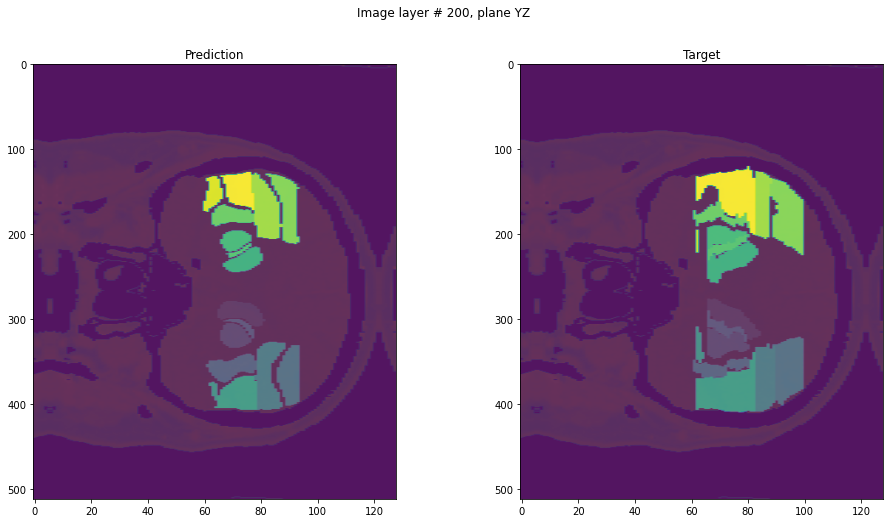

In [25]:
plane           = 'YZ'
predict_img_num = 1
sample_n        = 200
weights_file    = plane + '_a8b2d3_weights_cl.h5'

############################################################################################

model = load_2d_unet(input_shape=(512,128,1), num_labels=20, noise=0.0, dropout=0.2, init_filter=32)
model.compile(optimizer=Adam(learning_rate=0), loss=tversky_loss, metrics=[cce(), 'mse'])
model.load_weights(str(Path(os.getcwd(), weights_file)))
X_test, y_test = load_and_process_images(os.path.join(dataset_folder), predict_img_num, 'X')
X_test=X_test/np.max(X_test)
if X_test.shape[2]!=128:          
    delta = z_dim-X_test.shape[2]
    pad_left = int(delta/2)
    pad_right = delta-pad_left        
    X_test = np.pad(X_test, ((0,0),(0,0),(pad_left, pad_right)), mode='symmetric')
    y_test = np.pad(y_test, ((0,0),(0,0),(pad_left, pad_right)), mode='symmetric')
y_pred = np.zeros(X_test.shape+(20,), dtype='bool')
X_test = np.expand_dims(X_test, 3)
y_pred = model.predict(X_test)
y_pred[y_pred<threshold]=0
res = np.argmax(y_pred, axis=3)+1
y_pred=np.sum(y_pred, axis=3)
y_pred[y_pred!=0]=1
y_pred = y_pred*res
y_pred = y_pred.astype('int16')
X_test = X_test[...,0]

target_slice = y_test[sample_n,...]
pred_slice = y_pred[sample_n,...]
X_slice = X_test[sample_n,...]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8));
fig.suptitle('Image layer # %i, plane %s' % (sample_n, plane))
ax1.set_title('Prediction')
ax2.set_title('Target')
ax1.imshow(X_slice, alpha=.6, aspect=0.3), ax1.imshow(pred_slice, alpha=.8, aspect=0.3);
ax2.imshow(X_slice, alpha=.6, aspect=0.3), ax2.imshow(target_slice, alpha=.8, aspect=0.3);

#unpad prediction for saving
y_pred=y_pred[:,:,pad_left:-pad_right]

In [26]:
# сохранение сегментации
_, y_true = load_and_process_images(os.path.join(dataset_folder), predict_file[0], None, return_3D_arrays=False)
print('Go to img shape:', np.moveaxis(y_pred, (0,1), (1,2)).shape)
img = sitk.GetImageFromArray(np.moveaxis(y_pred, (0,1), (1,2)))
img.SetOrigin(y_true.GetOrigin())
img.SetSpacing(y_true.GetSpacing())
img.SetDirection(y_true.GetDirection())
sitk.WriteImage(img,os.path.join(str(predict_file[0])+'-'+plane+'-a8b2-seg-predicted.nii'))

Go to img shape: (116, 512, 512)


#### Расчет метрик

In [3]:
plane           = 'YZ'
predict_img_num = 1
sample_n        = 200
weights_file    = plane + '_a8b2d3_weights_cl.h5'

############################################################################################

model = load_2d_unet(input_shape=(512,128,1), num_labels=20, noise=0.0, dropout=0.2, init_filter=32)
model.compile(optimizer=Adam(learning_rate=0), loss=tversky_loss, metrics=[cce(), 'mse'])
model.load_weights(str(Path(os.getcwd(), weights_file)))

In [4]:
# расчет метрик для всех снимков
iou_df = pd.DataFrame(index=np.arange(1, n_output_channels+1))
fp_df = pd.DataFrame(index=np.arange(n_output_channels+1))
fn_df = pd.DataFrame(index=np.arange(n_output_channels+1))
misclass_df = pd.DataFrame(index=np.arange(n_output_channels+1))
totals_df = pd.DataFrame(index=['IoU'])

for i in range(7):    
    
    print('Image %s:' % str(i+1))   
    
    X_test, y_test = load_and_process_images(os.path.join(dataset_folder), i+1, 'X')

    X_test=X_test/np.max(X_test)

    # pad to 128px
    if X_test.shape[2]!=128:          
        delta = z_dim-X_test.shape[2]
        pad_left = int(delta/2)
        pad_right = delta-pad_left        
        X_test = np.pad(X_test, ((0,0),(0,0),(pad_left, pad_right)), mode='symmetric')
        y_test = np.pad(y_test, ((0,0),(0,0),(pad_left, pad_right)), mode='symmetric')
    
    y_pred = np.zeros(X_test.shape+(20,), dtype='bool')
    X_test = np.expand_dims(X_test, 3)
    
    test_generator  = BatchGenerator(X_test, X_test, np.arange(X_test.shape[0]), batch_size=1, shuffle=False)

    y_pred = model.predict(test_generator)
    y_pred[y_pred<threshold]=0
    res = np.argmax(y_pred, axis=3)+1
    y_pred=np.sum(y_pred, axis=3)
    y_pred[y_pred!=0]=1
    y_pred = y_pred*res
    y_pred = y_pred.astype('int16')    
    X_test = X_test[...,0]
   
    m = Metrics(y_test, y_pred)
    
    iou_df['Image '+str(i+1)]=m.classIoU
    fp_df['Image '+str(i+1)]=m.FP
    fn_df['Image '+str(i+1)]=m.FN
    misclass_df['Image '+str(i+1)]=m.misclass_rate
    totals_df['Image '+str(i+1)]=0.
    totals_df['Image '+str(i+1)][0]=m.IoU
    
fpfn_df = fp_df/fn_df
IoU_YZ = iou_df.iloc[0,0]
FPFN_rates_YZ = fpfn_df.iloc[1:,0].values
test_img_misclass_YZ = misclass_df['Image 1'][1:].values

Image 1:
Image 2:
Image 3:
Image 4:
Image 5:
Image 6:
Image 7:


#### Визуализация метрик

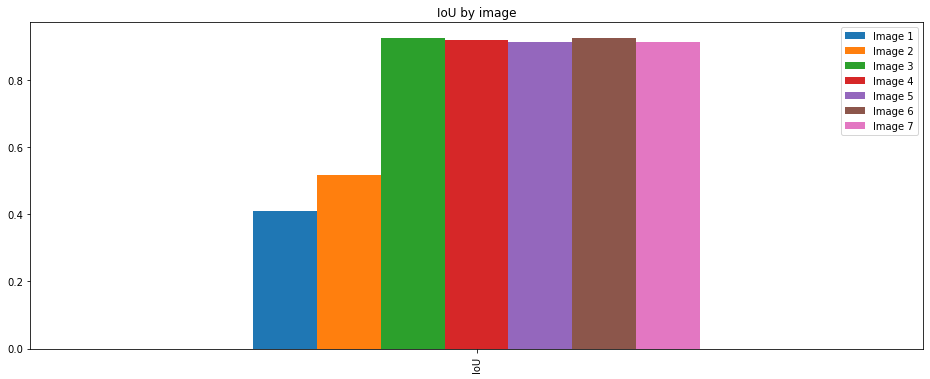

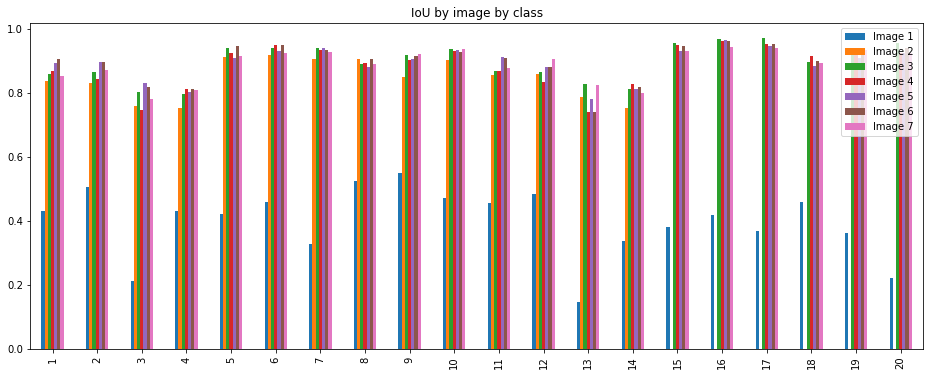

In [5]:
# визуализация метрик
from baseline_metrics import *
totals_df[totals_df.index=='IoU'].plot(kind='bar', title = 'IoU by image', figsize=(16,6));
iou_df.plot(title = 'IoU by image by class', kind='bar',figsize=(16,6));

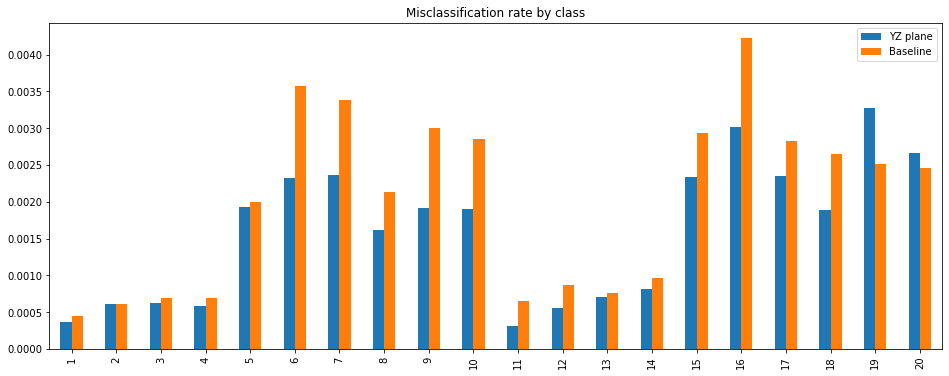

In [6]:
pd.DataFrame({'YZ plane': test_img_misclass_YZ,'Baseline':test_img_misclass_baseline},index=range(1,21)).plot(kind='bar', title='Misclassification rate by class', figsize=(16,6));

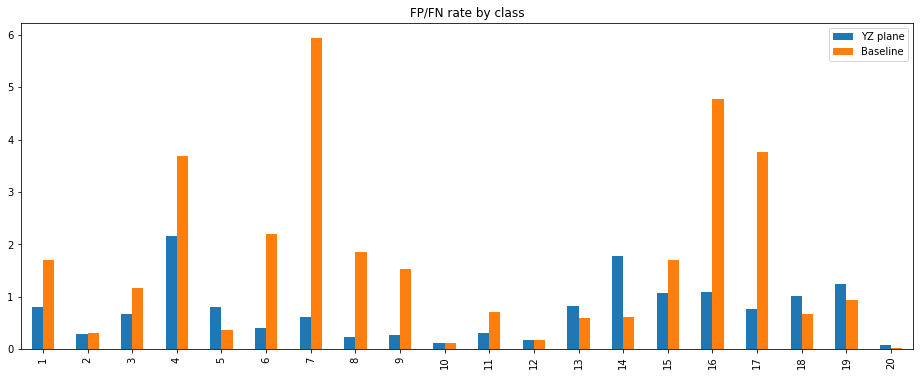

In [7]:
pd.DataFrame({'YZ plane': FPFN_rates_YZ,'Baseline':FPFN_rates_baseline},index=range(1,21)).plot(kind='bar', title='FP/FN rate by class', figsize=(16,6));

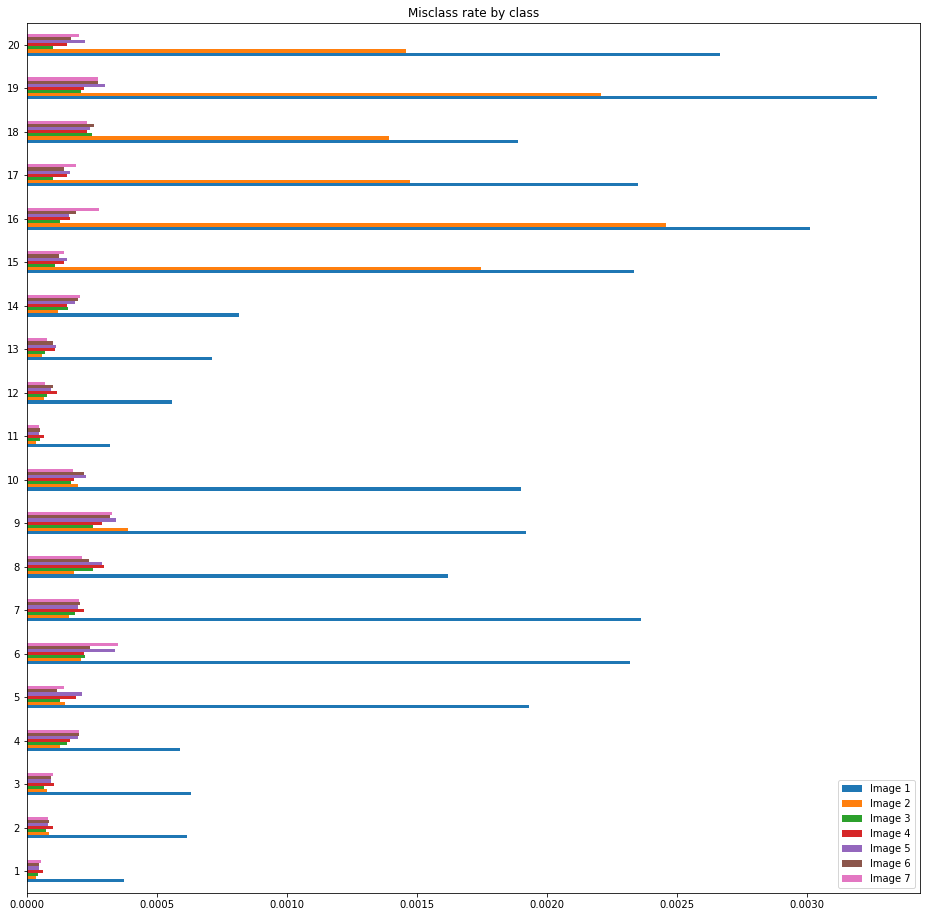

In [8]:
misclass_df[1:].plot(kind='barh', title = 'Misclass rate by class',figsize=(16,16));

#### Сравнение с baseline

In [9]:
# сравнение с baseline
print('For test image:\n\nIoU:: baseline %2.2f, YZ plane %2.2f\n' % (IoU_baseline, IoU_YZ))
print('Variance of FP/FN rates between classes:: baseline: %2.2f, YZ plane: %2.2f' % (np.var(FPFN_rates_baseline), np.var(FPFN_rates_YZ)))
print('Mean of FP/FN rates between classes::     baseline: %2.2f, YZ plane: %2.2f\n' % (np.mean(FPFN_rates_baseline), np.mean(FPFN_rates_YZ)))
print('Variance of misclassification rates between classes, *1e-6:: baseline: %2.2f, YZ plane: %2.2f' % (np.var(test_img_misclass_baseline)*1e6, np.var(test_img_misclass_YZ)*1e6))
print('Mean of misclassification rates between classes, *1e-3::     baseline: %2.2f, YZ plane: %2.2f' % (np.mean(test_img_misclass_baseline)*1e3, np.mean(test_img_misclass_YZ)*1e3))

For test image:

IoU:: baseline 0.41, YZ plane 0.43

Variance of FP/FN rates between classes:: baseline: 2.62, YZ plane: 0.29
Mean of FP/FN rates between classes::     baseline: 1.64, YZ plane: 0.73

Variance of misclassification rates between classes, *1e-6:: baseline: 1.35, YZ plane: 0.85
Mean of misclassification rates between classes, *1e-3::     baseline: 2.01, YZ plane: 1.61


#### Повтор обучения для alpha = 0.7, beta = 0.3, dropout = 0.3 -->

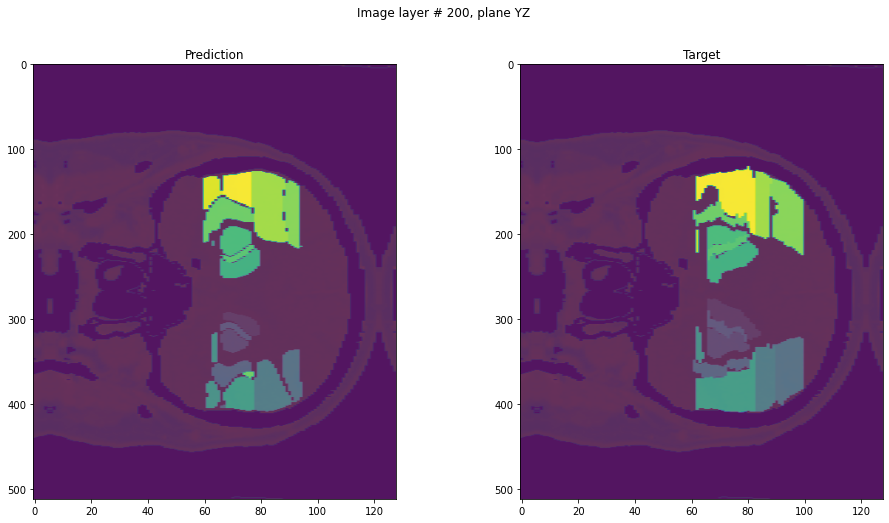

In [3]:
plane           = 'YZ'
predict_img_num = 1
sample_n        = 200
weights_file    = plane + '_a7b3d3_weights_cl.h5'

############################################################################################

model = load_2d_unet(input_shape=(512,128,1), num_labels=20, noise=0.0, dropout=0.2, init_filter=32)
model.compile(optimizer=Adam(learning_rate=0), loss=tversky_loss, metrics=[cce(), 'mse'])
model.load_weights(str(Path(os.getcwd(), weights_file)))
X_test, y_test = load_and_process_images(os.path.join(dataset_folder), predict_img_num, 'X')
X_test=X_test/np.max(X_test)
if X_test.shape[2]!=128:          
    delta = z_dim-X_test.shape[2]
    pad_left = int(delta/2)
    pad_right = delta-pad_left        
    X_test = np.pad(X_test, ((0,0),(0,0),(pad_left, pad_right)), mode='symmetric')
    y_test = np.pad(y_test, ((0,0),(0,0),(pad_left, pad_right)), mode='symmetric')
y_pred = np.zeros(X_test.shape+(20,), dtype='bool')
X_test = np.expand_dims(X_test, 3)
y_pred = model.predict(X_test)
y_pred[y_pred<threshold]=0
res = np.argmax(y_pred, axis=3)+1
y_pred=np.sum(y_pred, axis=3)
y_pred[y_pred!=0]=1
y_pred = y_pred*res
y_pred = y_pred.astype('int16')
X_test = X_test[...,0]

target_slice = y_test[sample_n,...]
pred_slice = y_pred[sample_n,...]
X_slice = X_test[sample_n,...]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8));
fig.suptitle('Image layer # %i, plane %s' % (sample_n, plane))
ax1.set_title('Prediction')
ax2.set_title('Target')
ax1.imshow(X_slice, alpha=.6, aspect=0.3), ax1.imshow(pred_slice, alpha=.8, aspect=0.3);
ax2.imshow(X_slice, alpha=.6, aspect=0.3), ax2.imshow(target_slice, alpha=.8, aspect=0.3);

#unpad prediction for saving
y_pred=y_pred[:,:,pad_left:-pad_right]

In [35]:
# сохранение сегментации
_, y_true = load_and_process_images(os.path.join(dataset_folder), predict_file[0], None, return_3D_arrays=False)
print('Go to img shape:', np.moveaxis(y_pred, (0,1), (1,2)).shape)
img = sitk.GetImageFromArray(np.moveaxis(y_pred, (0,1), (1,2)))
img.SetOrigin(y_true.GetOrigin())
img.SetSpacing(y_true.GetSpacing())
img.SetDirection(y_true.GetDirection())
sitk.WriteImage(img,os.path.join(str(predict_file[0])+'-'+plane+'-a7b3-seg-predicted.nii'))

Go to img shape: (116, 512, 512)


#### Расчет метрик

In [3]:
plane           = 'YZ'
predict_img_num = 1
sample_n        = 200
weights_file    = plane + '_a7b3d3_weights_cl.h5'

############################################################################################

model = load_2d_unet(input_shape=(512,128,1), num_labels=20, noise=0.0, dropout=0.2, init_filter=32)
model.compile(optimizer=Adam(learning_rate=0), loss=tversky_loss, metrics=[cce(), 'mse'])
model.load_weights(str(Path(os.getcwd(), weights_file)))

# расчет метрик для всех снимков
iou_df = pd.DataFrame(index=np.arange(1, n_output_channels+1))
fp_df = pd.DataFrame(index=np.arange(n_output_channels+1))
fn_df = pd.DataFrame(index=np.arange(n_output_channels+1))
misclass_df = pd.DataFrame(index=np.arange(n_output_channels+1))
totals_df = pd.DataFrame(index=['IoU'])

for i in range(7):    
    
    print('Image %s:' % str(i+1))   
    
    X_test, y_test = load_and_process_images(os.path.join(dataset_folder), i+1, 'X')

    X_test=X_test/np.max(X_test)

    # pad to 128px
    if X_test.shape[2]!=128:          
        delta = z_dim-X_test.shape[2]
        pad_left = int(delta/2)
        pad_right = delta-pad_left        
        X_test = np.pad(X_test, ((0,0),(0,0),(pad_left, pad_right)), mode='symmetric')
        y_test = np.pad(y_test, ((0,0),(0,0),(pad_left, pad_right)), mode='symmetric')
    
    y_pred = np.zeros(X_test.shape+(20,), dtype='bool')
    X_test = np.expand_dims(X_test, 3)
    
    test_generator  = BatchGenerator(X_test, X_test, np.arange(X_test.shape[0]), batch_size=1, shuffle=False)

    y_pred = model.predict(test_generator)
    y_pred[y_pred<threshold]=0
    res = np.argmax(y_pred, axis=3)+1
    y_pred=np.sum(y_pred, axis=3)
    y_pred[y_pred!=0]=1
    y_pred = y_pred*res
    y_pred = y_pred.astype('int16')    
    X_test = X_test[...,0]
   
    m = Metrics(y_test, y_pred)
    
    iou_df['Image '+str(i+1)]=m.classIoU
    fp_df['Image '+str(i+1)]=m.FP
    fn_df['Image '+str(i+1)]=m.FN
    misclass_df['Image '+str(i+1)]=m.misclass_rate
    totals_df['Image '+str(i+1)]=0.
    totals_df['Image '+str(i+1)][0]=m.IoU
    
fpfn_df = fp_df/fn_df
IoU_YZ = iou_df.iloc[0,0]
FPFN_rates_YZ = fpfn_df.iloc[1:,0].values
test_img_misclass_YZ = misclass_df['Image 1'][1:].values

Image 1:
Image 2:
Image 3:
Image 4:
Image 5:
Image 6:
Image 7:


#### Визуализация метрик

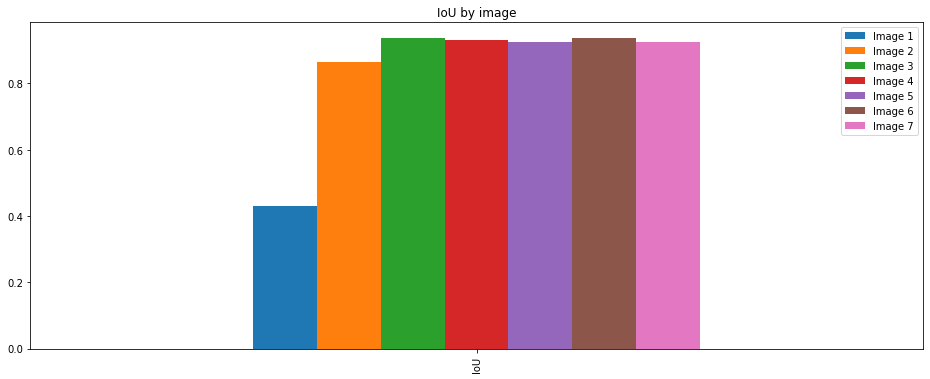

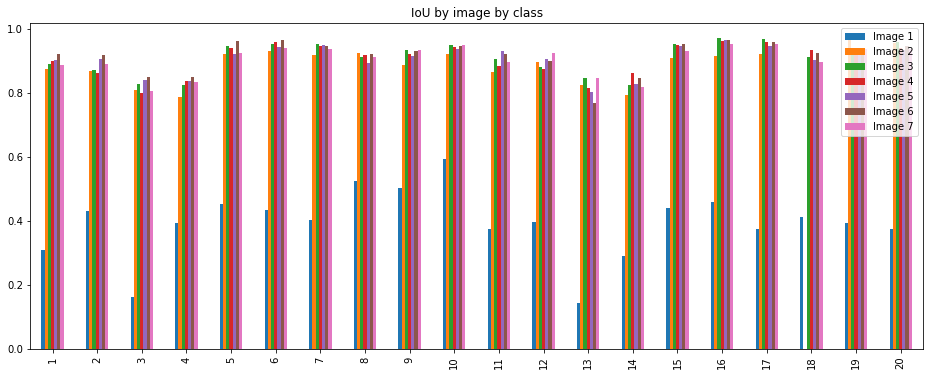

In [4]:
# визуализация метрик
from baseline_metrics import *
totals_df[totals_df.index=='IoU'].plot(kind='bar', title = 'IoU by image', figsize=(16,6));
iou_df.plot(title = 'IoU by image by class', kind='bar',figsize=(16,6));

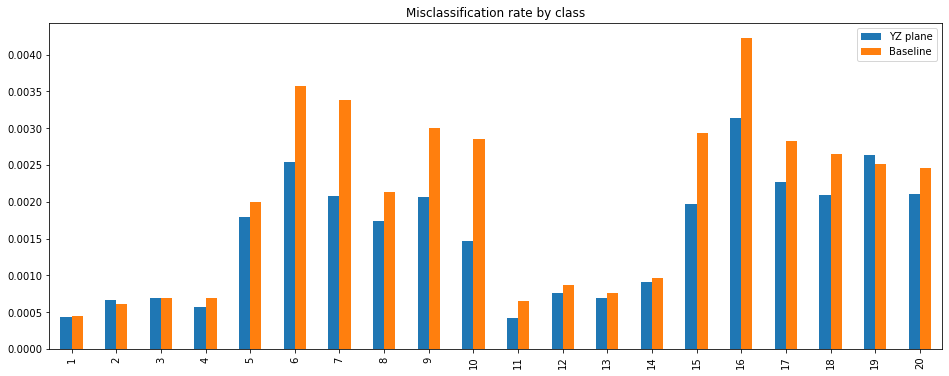

In [5]:
pd.DataFrame({'YZ plane': test_img_misclass_YZ,'Baseline':test_img_misclass_baseline},index=range(1,21)).plot(kind='bar', title='Misclassification rate by class', figsize=(16,6));

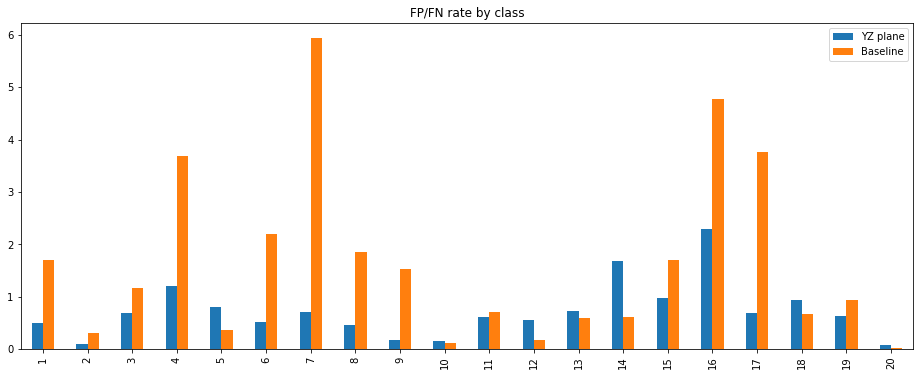

In [6]:
pd.DataFrame({'YZ plane': FPFN_rates_YZ,'Baseline':FPFN_rates_baseline},index=range(1,21)).plot(kind='bar', title='FP/FN rate by class', figsize=(16,6));

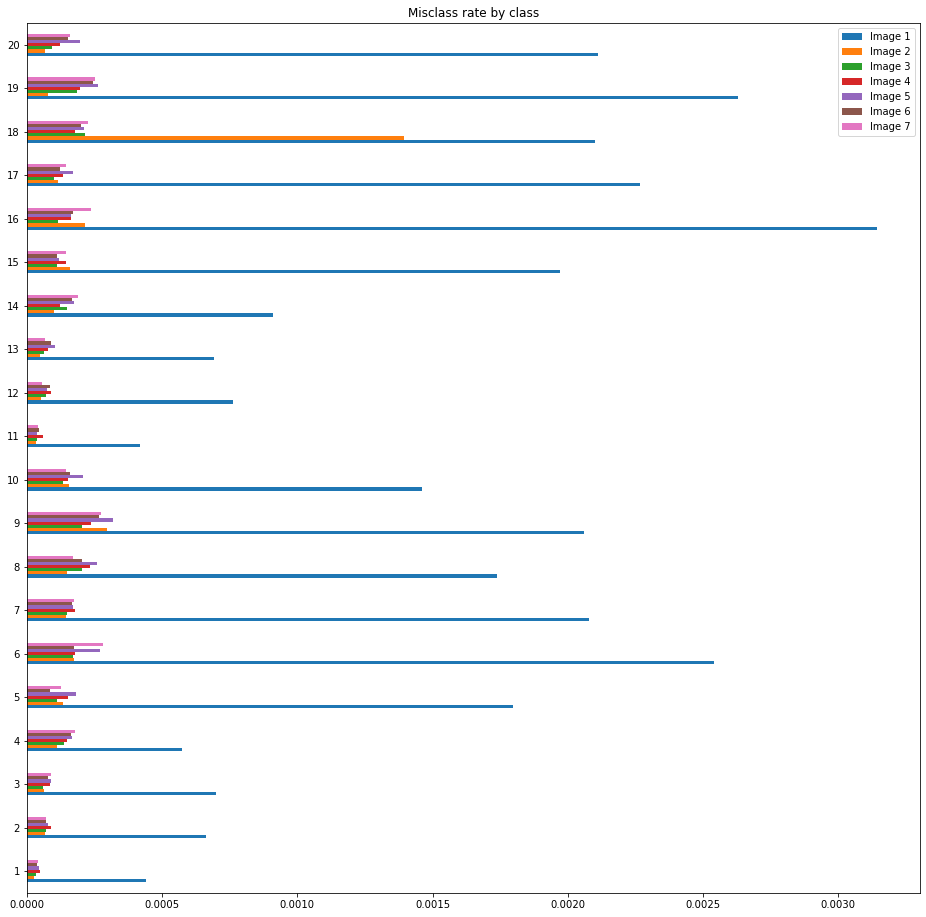

In [7]:
misclass_df[1:].plot(kind='barh', title = 'Misclass rate by class',figsize=(16,16));

#### Сравнение с baseline

In [8]:
# сравнение с baseline
print('For test image:\n\nIoU:: baseline %2.2f, YZ %2.2f\n' % (IoU_baseline, IoU_YZ))
print('Variance of FP/FN rates between classes:: baseline: %2.2f, YZ: %2.2f' % (np.var(FPFN_rates_baseline), np.var(FPFN_rates_YZ)))
print('Mean of FP/FN rates between classes::     baseline: %2.2f, YZ: %2.2f\n' % (np.mean(FPFN_rates_baseline), np.mean(FPFN_rates_YZ)))
print('Variance of misclassification rates between classes, *1e-6:: baseline: %2.2f, YZ: %2.2f' % (np.var(test_img_misclass_baseline)*1e6, np.var(test_img_misclass_YZ)*1e6))
print('Mean of misclassification rates between classes, *1e-3::     baseline: %2.2f, YZ: %2.2f' % (np.mean(test_img_misclass_baseline)*1e3, np.mean(test_img_misclass_YZ)*1e3))

For test image:

IoU:: baseline 0.41, YZ 0.31

Variance of FP/FN rates between classes:: baseline: 2.62, YZ: 0.27
Mean of FP/FN rates between classes::     baseline: 1.64, YZ: 0.72

Variance of misclassification rates between classes, *1e-6:: baseline: 1.35, YZ: 0.67
Mean of misclassification rates between classes, *1e-3::     baseline: 2.01, YZ: 1.55


IoU существенно упал, поэтому в качестве остальных весов оставляем предыдущие, где alpha = 0.8 и beta = 0.2.

### 7.2 Плоскость XZ

* Процесс обучения - в ноутбуке **XZ train in Colab.ipynb**

Гиперпараметры для обучения:
- alpha   = 0.85
- beta    = 0.15
- dropout = 0.3

#### Результаты сегментации в плоскости XZ

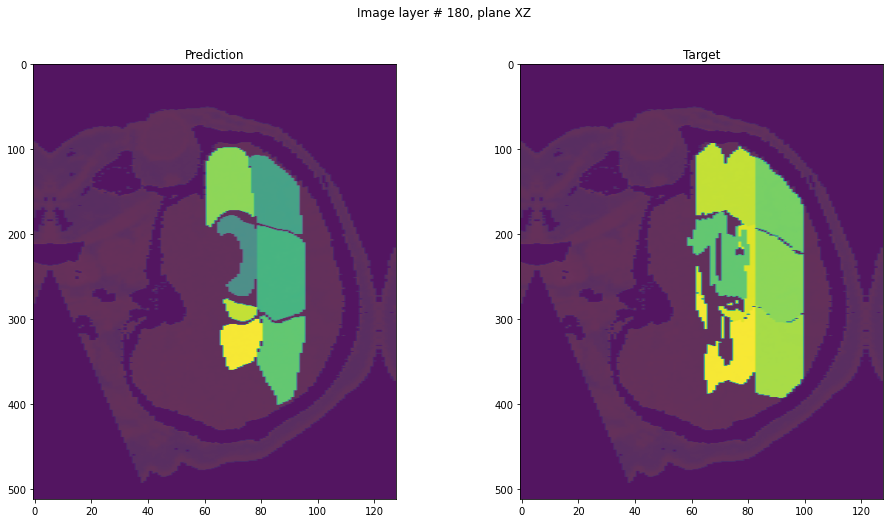

In [3]:
plane           = 'XZ'
predict_img_num = 1
sample_n        = 180
weights_file    = plane + '_a85b15d3_weights_cl.h5'

############################################################################################

model = load_2d_unet(input_shape=(512,128,1), num_labels=20, noise=0.0, dropout=0.2, init_filter=32)
model.compile(optimizer=Adam(learning_rate=0), loss=tversky_loss, metrics=[cce(), 'mse'])
model.load_weights(str(Path(os.getcwd(), weights_file)))

X_test, y_test = load_and_process_images(os.path.join(dataset_folder), predict_img_num, 'X')

X_test=X_test/np.max(X_test)

if X_test.shape[2]!=128:          
    delta = z_dim-X_test.shape[2]
    pad_left = int(delta/2)
    pad_right = delta-pad_left        
    X_test = np.pad(X_test, ((0,0),(0,0),(pad_left, pad_right)), mode='symmetric')
    y_test = np.pad(y_test, ((0,0),(0,0),(pad_left, pad_right)), mode='symmetric')
    
y_pred = np.zeros(X_test.shape+(20,), dtype='bool')
X_test = np.expand_dims(X_test, 3)

X_test = np.moveaxis(X_test, 0,1)
y_test = np.moveaxis(y_test, 0,1)

y_pred = model.predict(X_test)
y_pred[y_pred<threshold]=0
res = np.argmax(y_pred, axis=3)+1
y_pred=np.sum(y_pred, axis=3)
y_pred[y_pred!=0]=1
y_pred = y_pred*res
y_pred = y_pred.astype('int16')
X_test = X_test[...,0]

target_slice = y_test[sample_n,...]
pred_slice = y_pred[sample_n,...]
X_slice = X_test[sample_n,...]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8));
fig.suptitle('Image layer # %i, plane %s' % (sample_n, plane))
ax1.set_title('Prediction')
ax2.set_title('Target')
ax1.imshow(X_slice, alpha=.6, aspect=0.3), ax1.imshow(pred_slice, alpha=.8, aspect=0.3);
ax2.imshow(X_slice, alpha=.6, aspect=0.3), ax2.imshow(target_slice, alpha=.8, aspect=0.3);

#unpad and unswap axes for saving
X_test = np.moveaxis(X_test, 0,1)
y_test = np.moveaxis(y_test, 0,1)
y_pred = np.moveaxis(y_pred, 0,1)
y_pred=y_pred[:,:,pad_left:-pad_right]

In [4]:
# сохранение сегментации
_, y_true = load_and_process_images(os.path.join(dataset_folder), predict_file[0], None, return_3D_arrays=False)
print('Go to img shape:', np.moveaxis(y_pred, (0,1), (1,2)).shape)
img = sitk.GetImageFromArray(np.moveaxis(y_pred, (0,1), (1,2)))
img.SetOrigin(y_true.GetOrigin())
img.SetSpacing(y_true.GetSpacing())
img.SetDirection(y_true.GetDirection())
sitk.WriteImage(img,os.path.join(str(predict_file[0])+'-'+plane+'-a85b15-seg-predicted.nii'))

Go to img shape: (116, 512, 512)


#### Расчет метрик

In [4]:
plane           = 'XZ'
predict_img_num = 1
sample_n        = 180
weights_file    = plane + '_a85b15d3_weights_cl.h5'

############################################################################################

model = load_2d_unet(input_shape=(512,128,1), num_labels=20, noise=0.0, dropout=0.2, init_filter=32)
model.compile(optimizer=Adam(learning_rate=0), loss=tversky_loss, metrics=[cce(), 'mse'])
model.load_weights(str(Path(os.getcwd(), weights_file)))

# расчет метрик для всех снимков
iou_df = pd.DataFrame(index=np.arange(1, n_output_channels+1))
fp_df = pd.DataFrame(index=np.arange(n_output_channels+1))
fn_df = pd.DataFrame(index=np.arange(n_output_channels+1))
misclass_df = pd.DataFrame(index=np.arange(n_output_channels+1))
totals_df = pd.DataFrame(index=['IoU'])

for i in range(7):    
    
    print('Image %s:' % str(i+1))   
    
    X_test, y_test = load_and_process_images(os.path.join(dataset_folder), i+1, 'X')

    X_test=X_test/np.max(X_test)

    # pad to 128px
    if X_test.shape[2]!=128:          
        delta = z_dim-X_test.shape[2]
        pad_left = int(delta/2)
        pad_right = delta-pad_left        
        X_test = np.pad(X_test, ((0,0),(0,0),(pad_left, pad_right)), mode='symmetric')
        y_test = np.pad(y_test, ((0,0),(0,0),(pad_left, pad_right)), mode='symmetric')
    
    y_pred = np.zeros(X_test.shape+(20,), dtype='bool')
    X_test = np.expand_dims(X_test, 3)
    
    X_test = np.moveaxis(X_test, 0,1)
    y_test = np.moveaxis(y_test, 0,1)
    
    test_generator  = BatchGenerator(X_test, y_test, np.arange(X_test.shape[0]), batch_size=1, shuffle=False)

    y_pred = model.predict(test_generator)
    y_pred[y_pred<threshold]=0
    res = np.argmax(y_pred, axis=3)+1
    y_pred=np.sum(y_pred, axis=3)
    y_pred[y_pred!=0]=1
    y_pred = y_pred*res
    y_pred = y_pred.astype('int16')     
    
    X_test = np.moveaxis(X_test,0,1)
    y_pred = np.moveaxis(y_pred,0,1)
    y_test = np.moveaxis(y_test,0,1)    
    
    X_test = X_test[...,0]
   
    m = Metrics(y_test, y_pred)
    
    iou_df['Image '+str(i+1)]=m.classIoU
    fp_df['Image '+str(i+1)]=m.FP
    fn_df['Image '+str(i+1)]=m.FN
    misclass_df['Image '+str(i+1)]=m.misclass_rate
    totals_df['Image '+str(i+1)]=0.
    totals_df['Image '+str(i+1)][0]=m.IoU
    
fpfn_df = fp_df/fn_df
IoU_XZ = iou_df.iloc[0,0]
FPFN_rates_XZ = fpfn_df.iloc[1:,0].values
test_img_misclass_XZ = misclass_df['Image 1'][1:].values

Image 1:
Image 2:
Image 3:
Image 4:
Image 5:
Image 6:
Image 7:


#### Визуализация метрик

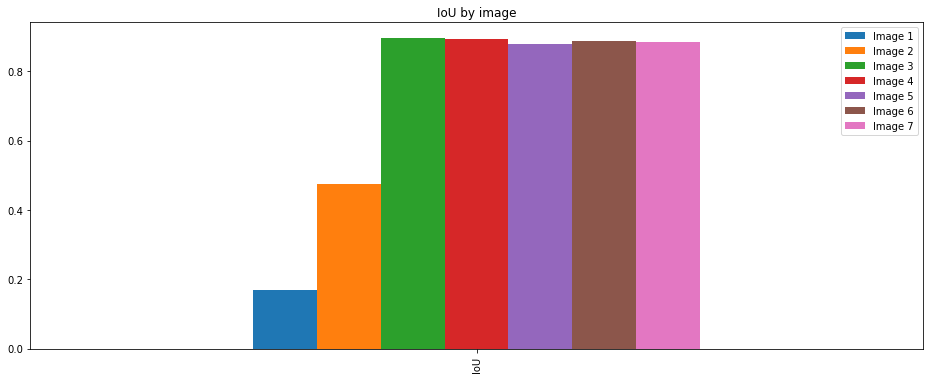

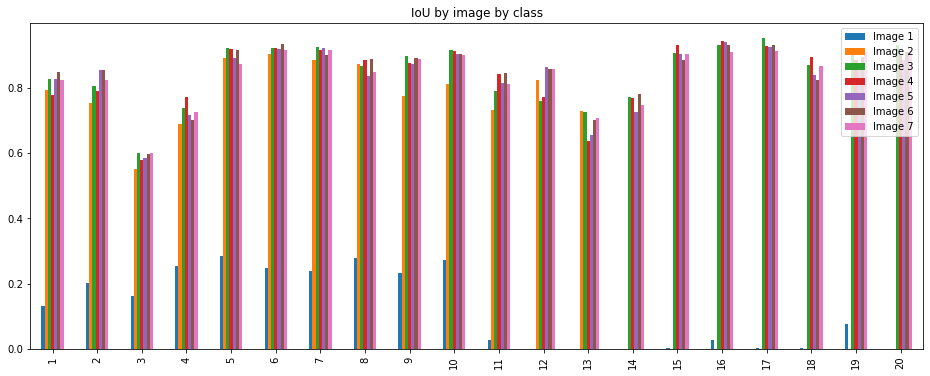

In [5]:
# визуализация метрик
from baseline_metrics import *
totals_df[totals_df.index=='IoU'].plot(kind='bar', title = 'IoU by image', figsize=(16,6));
iou_df.plot(title = 'IoU by image by class', kind='bar',figsize=(16,6));

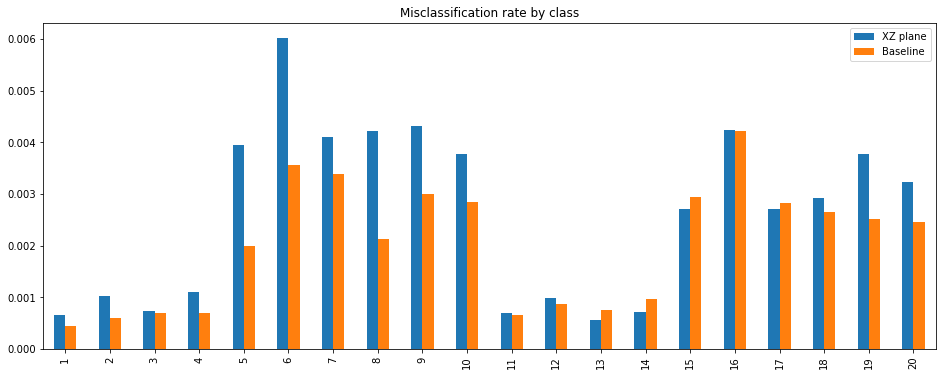

In [6]:
pd.DataFrame({'XZ plane': test_img_misclass_XZ,'Baseline':test_img_misclass_baseline},index=range(1,21)).plot(kind='bar', title='Misclassification rate by class', figsize=(16,6));

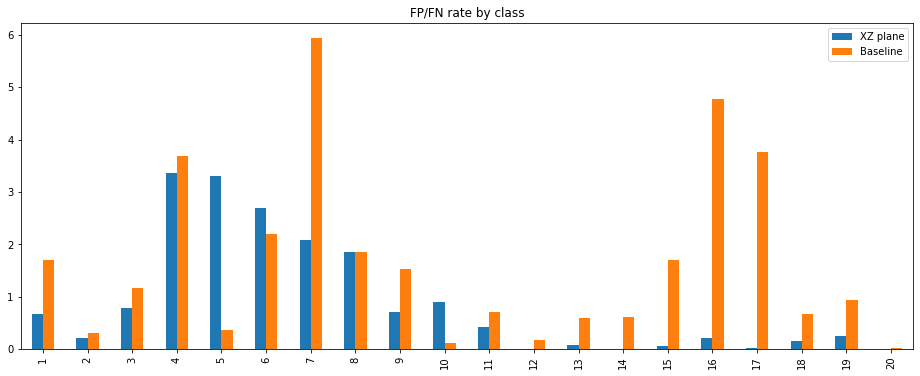

In [7]:
pd.DataFrame({'XZ plane': FPFN_rates_XZ,'Baseline':FPFN_rates_baseline},index=range(1,21)).plot(kind='bar', title='FP/FN rate by class', figsize=(16,6));

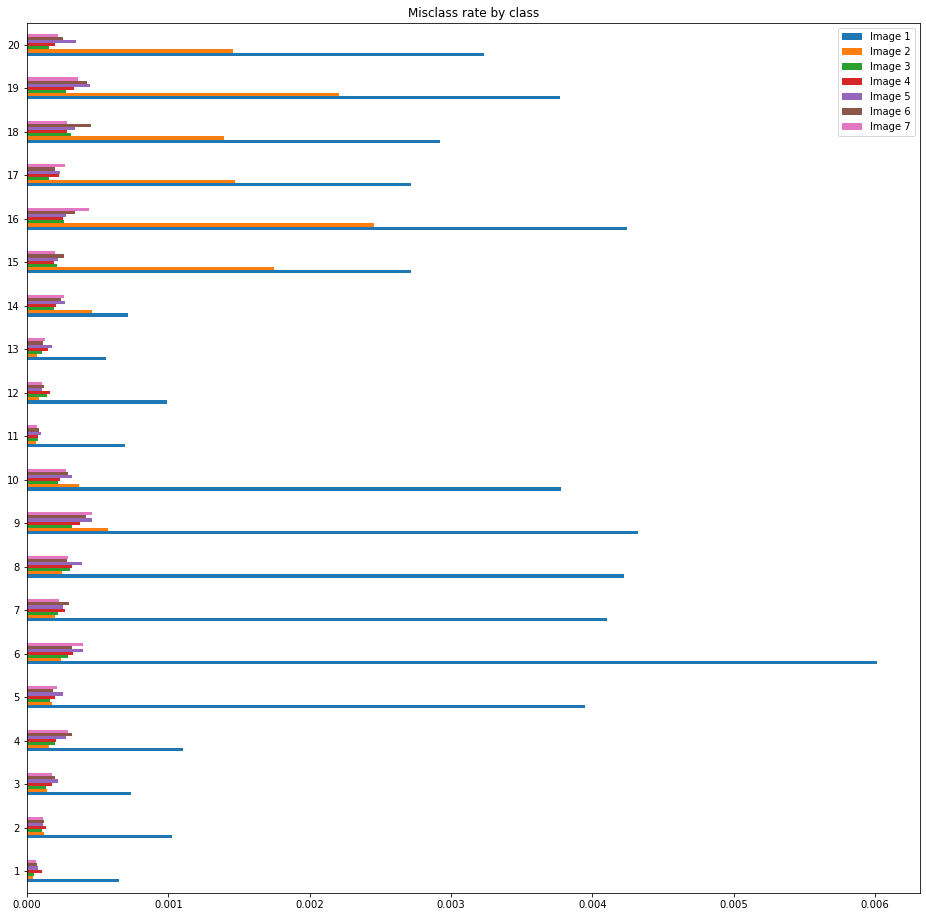

In [8]:
misclass_df[1:].plot(kind='barh', title = 'Misclass rate by class',figsize=(16,16));

#### Сравнение с baseline

In [9]:
# сравнение с baseline
print('For test image:\n\nIoU:: baseline %2.2f, XZ plane %2.2f\n' % (IoU_baseline, IoU_XZ))
print('Variance of FP/FN rates between classes:: baseline: %2.2f, XZ plane: %2.2f' % (np.var(FPFN_rates_baseline), np.var(FPFN_rates_XZ)))
print('Mean of FP/FN rates between classes::     baseline: %2.2f, XZ plane: %2.2f\n' % (np.mean(FPFN_rates_baseline), np.mean(FPFN_rates_XZ)))
print('Variance of misclassification rates between classes, *1e-6:: baseline: %2.2f, XZ plane: %2.2f' % (np.var(test_img_misclass_baseline)*1e6, np.var(test_img_misclass_XZ)*1e6))
print('Mean of misclassification rates between classes, *1e-3::     baseline: %2.2f, XZ plane: %2.2f' % (np.mean(test_img_misclass_baseline)*1e3, np.mean(test_img_misclass_XZ)*1e3))

For test image:

IoU:: baseline 0.41, XZ plane 0.13

Variance of FP/FN rates between classes:: baseline: 2.62, XZ plane: 1.21
Mean of FP/FN rates between classes::     baseline: 1.64, XZ plane: 0.89

Variance of misclassification rates between classes, *1e-6:: baseline: 1.35, XZ plane: 2.66
Mean of misclassification rates between classes, *1e-3::     baseline: 2.01, XZ plane: 2.62


В плоскости XZ результат сегментации плохой. Распределение FP/FN выглядит хорошо, но очень велика ошибка определения класса по сравнению с бейзлайном. Этого и следовало ожидать, потому что разметка симметрична относительно плоскости ХZ, но имеет при этом разные классы, и сеть при анализе такого типа не может различить левую и правую стороны мозга. Об этом было не подумано на этапе выбора архитектуры сети.

Непонятно пока, есть ли смысл добавлять этот результат в ансамбль.

#### Исправление ошибки в плоскости XZ

In [193]:
# очень стыдно
# исправляем методическую ошибку симметрии в плоскости XZ заменой классов в предсказанной сегментации
wrong_file = sitk.ReadImage('1-XZ_wrong-a85b15-seg-predicted.nii')
prediction = sitk.GetArrayFromImage(wrong_file)

In [194]:
# пусть это ось симметрии головы, там должно быть пусто
div_plane = 274 
np.sum(prediction[:, :, div_plane])

0

In [195]:
# замена разметки
left_array = prediction[:,:,:div_plane]
right_array = prediction[:,:,div_plane:]
right_array[right_array>10]-=10
left_array[left_array==0]=-10
left_array[left_array<=10]+=10

In [196]:
# сохранение исправленной сегментации
img = sitk.GetImageFromArray(prediction)
img.SetOrigin(wrong_file.GetOrigin())
img.SetSpacing(wrong_file.GetSpacing())
img.SetDirection(wrong_file.GetDirection())
sitk.WriteImage(img,os.path.join('1-XZ-seg-predicted.nii'))

## 8. Объединение полученных сегментаций

In [5]:
prediction_files={}

# index files
for fname in os.listdir():
    if '-seg-predicted.nii' in fname:
        if 'XY' in fname:
            prediction_files['XY'] = fname
        if 'XZ' in fname:
            prediction_files['XZ'] = fname
        if 'YZ' in fname:
            prediction_files['YZ'] = fname
assert len(prediction_files)==3, 'Some files are missing'

In [6]:
prediction_files

{'XY': '1-XY-seg-predicted.nii',
 'XZ': '1-XZ-seg-predicted.nii',
 'YZ': '1-YZ-a8b2-seg-predicted.nii'}

### Объединение трёх сегментаций

In [222]:
# create and fill resulting array
seg = np.zeros(sitk.GetArrayFromImage(sitk.ReadImage(prediction_files['XY'])).shape+(3,), dtype='int16')
res = np.zeros(sitk.GetArrayFromImage(sitk.ReadImage(prediction_files['XY'])).shape, dtype='int16')
for i, key in enumerate(prediction_files.keys()):
    seg[...,i] = sitk.GetArrayFromImage(sitk.ReadImage(prediction_files[key]))
seg.shape

(116, 512, 512, 3)

In [223]:
# уже не хватило времени исключaть циклы
for x in range(seg.shape[1]):
    if x in np.linspace(0, 500, 11):
        print('Current X coordinate:', x)
    for y in range(seg.shape[2]):
        for z in range(seg.shape[0]):
            u, c = np.unique(seg[z,x,y,:], return_counts=True)
            if (2 in c) or (3 in c):
                res[z,x,y] = u[np.argmax(c)]

Current X coordinate: 0
Current X coordinate: 50
Current X coordinate: 100
Current X coordinate: 150
Current X coordinate: 200
Current X coordinate: 250
Current X coordinate: 300
Current X coordinate: 350
Current X coordinate: 400
Current X coordinate: 450
Current X coordinate: 500


In [224]:
_, y_true = load_and_process_images(os.path.join(dataset_folder), predict_file[0], None, return_3D_arrays=False)
print('Go to img shape:', res.shape)
img = sitk.GetImageFromArray(res)
img.SetOrigin(y_true.GetOrigin())
img.SetSpacing(y_true.GetSpacing())
img.SetDirection(y_true.GetDirection())
sitk.WriteImage(img, os.path.join(str(predict_file[0])+'_XY+YZ+XZ-seg-predicted.nii'))

Go to img shape: (116, 512, 512)


#### Расчет метрик

In [8]:
# расчет метрик

_, y_true = load_and_process_images(os.path.join(dataset_folder), predict_file[0], None, return_3D_arrays=False)
res = sitk.GetArrayFromImage(sitk.ReadImage(str(predict_file[0])+'_XY+YZ+XZ-seg-predicted.nii'))

plane='XY+YZ+XZ'

iou_df = pd.DataFrame(index=np.arange(1, n_output_channels+1))
fp_df = pd.DataFrame(index=np.arange(n_output_channels+1))
fn_df = pd.DataFrame(index=np.arange(n_output_channels+1))
misclass_df = pd.DataFrame(index=np.arange(n_output_channels+1))
totals_df = pd.DataFrame(index=['IoU'])
   
m = Metrics(sitk.GetArrayFromImage(y_true), res)

iou_df['Image 1']=m.classIoU
fp_df['Image 1']=m.FP
fn_df['Image 1']=m.FN
misclass_df['Image 1']=m.misclass_rate
totals_df['Image 1']=0.
totals_df['Image 1'][0]=m.IoU
    
fpfn_df = fp_df/fn_df
FPFN_rates_XYZ = fpfn_df.iloc[1:,0].values
test_img_misclass_XYZ = misclass_df['Image 1'][1:].values

#### Визуализация метрик

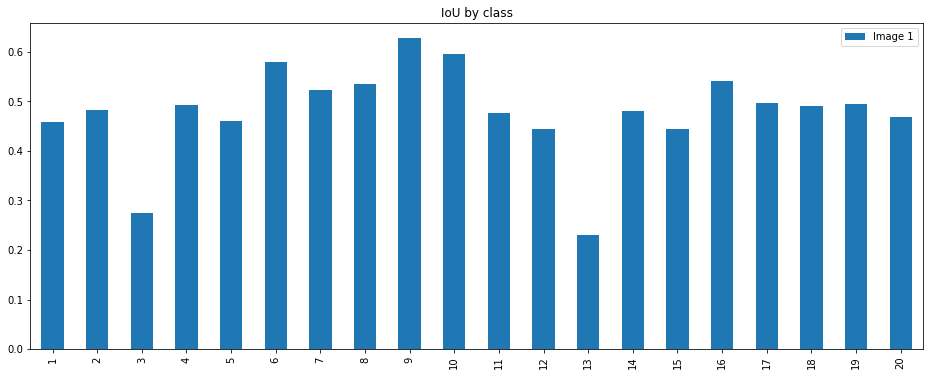

In [9]:
# визуализация метрик
from baseline_metrics import *
iou_df.plot(title = 'IoU by class', kind='bar',figsize=(16,6));

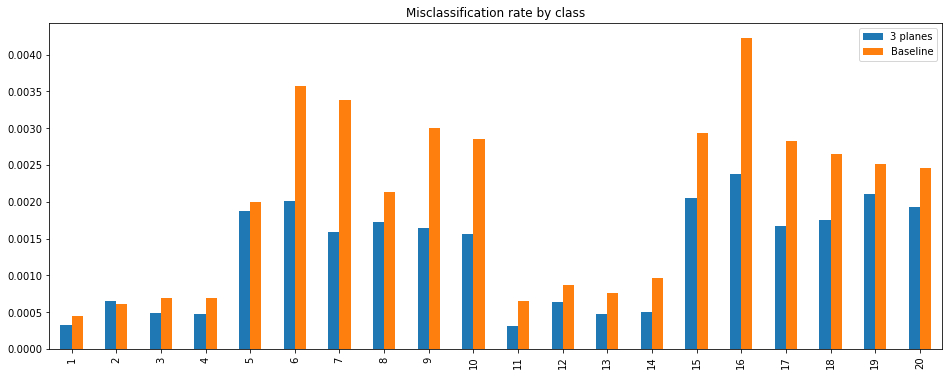

In [10]:
pd.DataFrame({'3 planes': test_img_misclass_XYZ,'Baseline':test_img_misclass_baseline},index=range(1,21)).plot(kind='bar', title='Misclassification rate by class', figsize=(16,6));

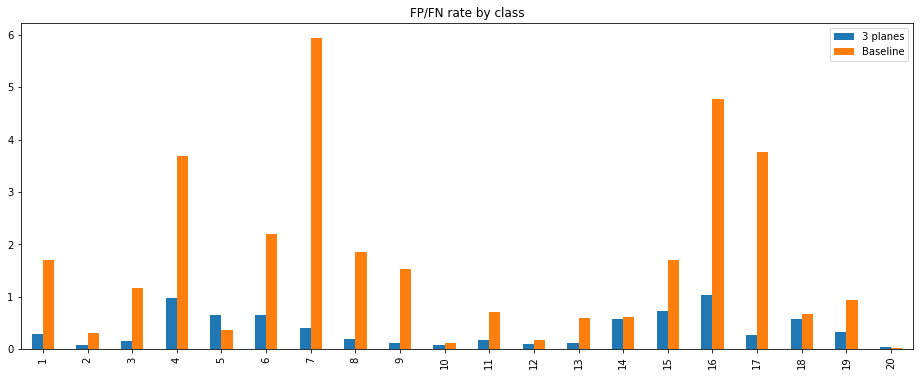

In [11]:
pd.DataFrame({'3 planes': FPFN_rates_XYZ,'Baseline':FPFN_rates_baseline},index=range(1,21)).plot(kind='bar', title='FP/FN rate by class', figsize=(16,6));

#### Сравнение с baseline

In [12]:
# сравнение с baseline
IoU_XYZ = iou_df.iloc[0,0]
FPFN_rates_XYZ = fpfn_df.iloc[1:,0].values
test_img_misclass_XYZ = misclass_df['Image 1'][1:].values
print('For test image, XY-YZ-XZ:\n\nIoU:: baseline %2.2f, 3 planes sum %2.2f\n' % (IoU_baseline, IoU_XYZ))
print('Variance of FP/FN rates between classes:: baseline: %2.2f, 3 planes: %2.2f' % (np.var(FPFN_rates_baseline), np.var(FPFN_rates_XYZ)))
print('Mean of FP/FN rates between classes::     baseline: %2.2f, 3 planes: %2.2f\n' % (np.mean(FPFN_rates_baseline), np.mean(FPFN_rates_XYZ)))
print('Variance of misclassification rates between classes, *1e-6:: baseline: %2.2f, 3 planes: %2.2f' % (np.var(test_img_misclass_baseline)*1e6, np.var(test_img_misclass_XYZ)*1e6))
print('Mean of misclassification rates between classes, *1e-3::     baseline: %2.2f, 3 planes: %2.2f' % (np.mean(test_img_misclass_baseline)*1e3, np.mean(test_img_misclass_XYZ)*1e3))

For test image, XY-YZ-XZ:

IoU:: baseline 0.41, 3 planes sum 0.46

Variance of FP/FN rates between classes:: baseline: 2.62, 3 planes: 0.09
Mean of FP/FN rates between classes::     baseline: 1.64, 3 planes: 0.37

Variance of misclassification rates between classes, *1e-6:: baseline: 1.35, 3 planes: 0.49
Mean of misclassification rates between classes, *1e-3::     baseline: 2.01, 3 planes: 1.31


In [73]:
gt = sitk.ReadImage(os.path.join('source_data', '1-seg.nii'))
y_true = sitk.GetArrayFromImage(gt)
y_pred = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join('1_XY+YZ+XZ-seg-predicted.nii')))

In [74]:
y_pred.shape, y_true.shape

((116, 512, 512), (116, 512, 512))

In [77]:
y_pred=y_pred.astype('uint16')

In [78]:
np.unique(y_pred), np.unique(y_true)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20], dtype=uint16),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20], dtype=uint16))

In [79]:
y_res = np.zeros_like(y_true)

In [94]:
y_res = np.where(y_true!=y_pred, y_true, np.zeros_like(y_true))

In [95]:
np.sum(y_res), np.sum(y_true), np.sum(y_pred)

(6996628, 16813913, 12340439)

In [96]:
img = sitk.GetImageFromArray(y_res)
img.SetOrigin(gt.GetOrigin())
img.SetSpacing(gt.GetSpacing())
img.SetDirection(gt.GetDirection())
sitk.WriteImage(img, os.path.join(str(predict_file[0])+'_T_P_difference.nii'))